In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W0929 12:20:42.736357 140486737778496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0929 12:20:42.737206 140486737778496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0929 12:20:42.742168 140486737778496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



# Reading Data

In [3]:
path = '/home/ricardo/TCC/'

In [4]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [5]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Normalazing Data

In [6]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Separating the Data in anomaly and not anomaly

In [7]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

# Balanced Data

### Verifying how unbalanced is our dataset

Text(0.5, 1.0, '8.951238929246692')

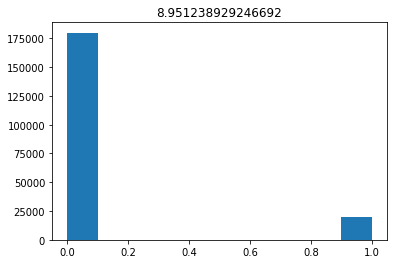

In [8]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

### To balance the data we will eliminate some not anomaly samples

In [9]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)

### Verifying if it is balanced now

Text(0.5, 1.0, '2.2377848542143495')

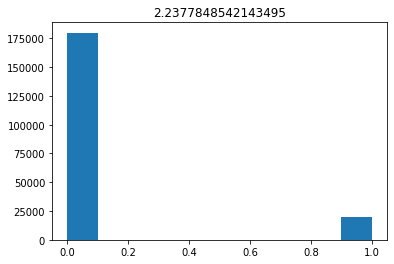

In [10]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

# Separating in Train, Val and Test data

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [12]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

### Verifying the size of each dataframe

In [13]:
print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


# Importing some metrics to evaluating the models.

In [14]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Here we have 3 differents model, each of them will make a especific work:

- The best non anomaly predictor.
- The best anomaly predictor.
- Balanced predictor.

To make algorithm do some especific job you need to change the threshold and analyse the results.

In [16]:
model3 = load_model(path+'Undersampling/h5_models/RNA3_elim.h5', custom_objects={'f1': f1})
model5 = load_model(path+'Undersampling/h5_models/RNA5_elim.h5', custom_objects={'f1': f1})
model1 = load_model(path+'Undersampling/h5_models/RNA1_elim.h5', custom_objects={'f1': f1})
# model= load_model('model_newData.h5', custom_objects={'f1': f1})

W0927 16:12:33.559948 140604120913728 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 16:12:33.562803 140604120913728 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 16:12:33.586143 140604120913728 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0927 16:12:33.766741 140604120913728 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.tra

In [17]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [18]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [19]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


## Model 3


In [20]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [21]:
prob_m3 = np.ravel(model3.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision_m3,recall_m3,f1_m3,yprob_m3 = choosing_threshold(y_data[0],prob_m3,threshold_list)

In [22]:
print('precision values: {}'.format(precision_m3))
print('recall values: {}'.format(recall_m3))
print('f1 values: {}'.format(f1_m3))

precision values: [0.4360007800819086, 0.48709518950988173, 0.5318616883676813, 0.5754238939777822, 0.61282529922038, 0.6473716381418093, 0.6809151938621729, 0.7124368203400214, 0.7432594882363043, 0.7745917573872473, 0.8028215952010664, 0.8266734538050394, 0.8535564853556485, 0.875313957660567, 0.899546485260771, 0.9253914645379183, 0.9516932270916335, 0.9860935524652339]
recall values: [0.9487233892071575, 0.9116627767168823, 0.8724803734351793, 0.8352783082254757, 0.7894476271306315, 0.7490628757337859, 0.7030200155597991, 0.657967324421812, 0.6122073696866822, 0.5636183605629819, 0.5111394016549968, 0.45943843270386875, 0.4039889666878846, 0.3450739090459014, 0.28057146898649127, 0.21316924817879623, 0.13515807341396138, 0.05516656057712709]
f1 values: [0.5974390379690457, 0.6349440914240677, 0.6608630434200305, 0.6814182269278481, 0.6900132908849257, 0.6945145742483361, 0.6917910707450327, 0.684119572011619, 0.671398099670351, 0.6524747205960617, 0.6246056782334385, 0.590625994453

#### Above you can see the confusion matrix for all the thresholds

Normalized confusion matrix
[[0.44759964 0.55240036]
 [0.05127661 0.94872339]]
Normalized confusion matrix
[[0.56790399 0.43209601]
 [0.08833722 0.91166278]]
Normalized confusion matrix
[[0.65433592 0.34566408]
 [0.12751963 0.87248037]]
Normalized confusion matrix
[[0.72259009 0.27740991]
 [0.16472169 0.83527831]]
Normalized confusion matrix
[[0.77549981 0.22450019]
 [0.21055237 0.78944763]]
Normalized confusion matrix
[[0.81634407 0.18365593]
 [0.25093712 0.74906288]]
Normalized confusion matrix
[[0.85171272 0.14828728]
 [0.29697998 0.70302002]]
Normalized confusion matrix
[[0.8804597  0.1195403 ]
 [0.34203268 0.65796732]]
Normalized confusion matrix
[[0.90481345 0.09518655]
 [0.38779263 0.61220737]]
Normalized confusion matrix
[[0.92617471 0.07382529]
 [0.43638164 0.56361836]]
Normalized confusion matrix
[[0.94349293 0.05650707]
 [0.4888606  0.5111394 ]]
Normalized confusion matrix
[[0.95664077 0.04335923]
 [0.54056157 0.45943843]]
Normalized confusion matrix
[[0.96880173 0.03119827]

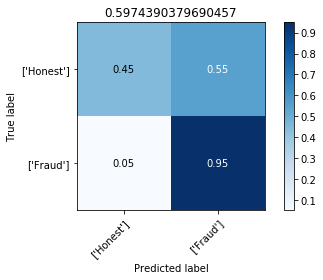

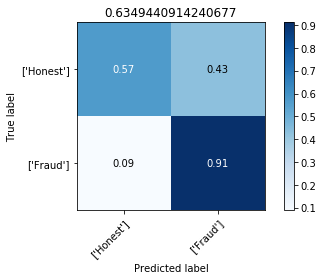

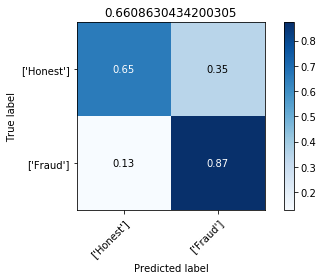

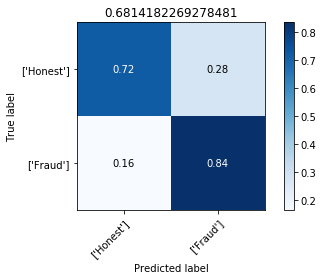

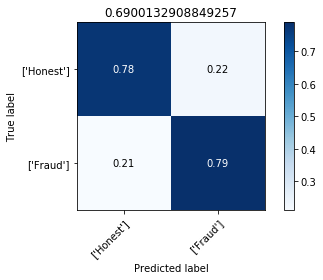

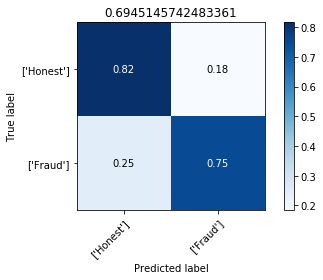

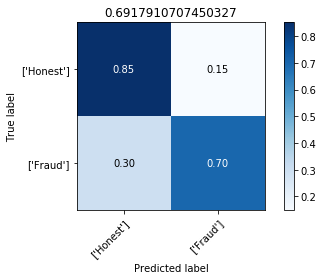

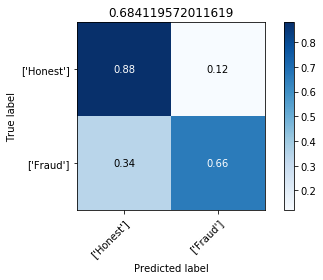

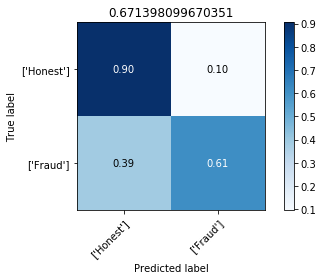

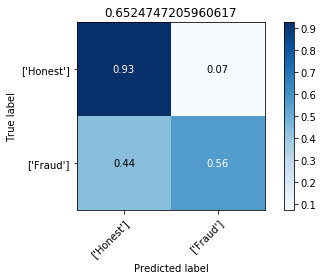

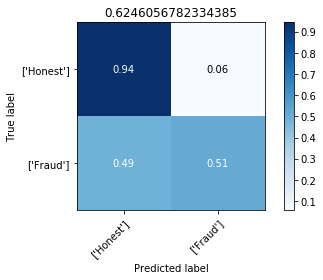

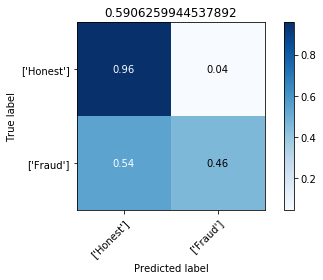

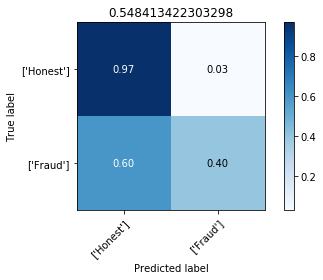

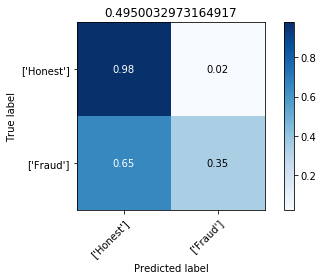

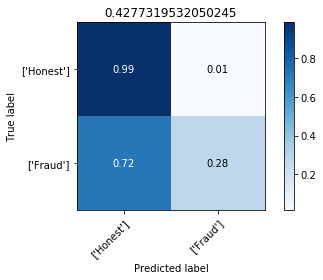

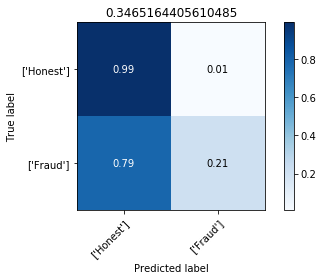

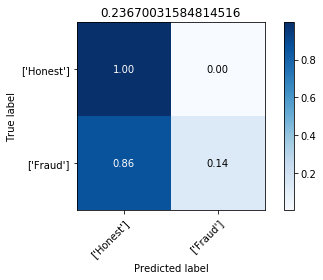

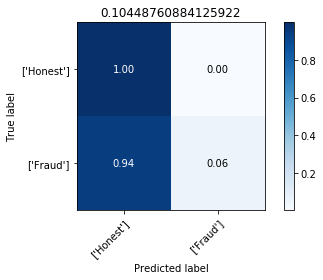

In [23]:
for i in range(len(yprob_m3)):
    plot_confusion_matrix(y_data[0], yprob_m3[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_m3[i],
                          cmap=plt.cm.Blues)

## Model5


In [24]:
prob_m5 = np.ravel(model5.predict(x_data[0]))
precision_m5,recall_m5,f1_m5,yprob_m5 = choosing_threshold(y_data[0],prob_m5,threshold_list)

In [25]:
print('precision values: {}'.format(precision_m5))
print('recall values: {}'.format(recall_m5))
print('f1 values: {}'.format(f1_m5))

precision values: [0.41540434888834593, 0.463356224687445, 0.5057114427860696, 0.5431207380665865, 0.5810083698684735, 0.6169834389240858, 0.6470046082949309, 0.6789217367446327, 0.7114140480591498, 0.7424685832329144, 0.7728426395939086, 0.8021546403321738, 0.8288323548597522, 0.8577708006279435, 0.8850485436893204, 0.911116937598322, 0.9417967102488402, 0.9749478079331941]
recall values: [0.9620199448334394, 0.9305467147605913, 0.8986491265294575, 0.8618714194780395, 0.8248108069877643, 0.7852040455477757, 0.7447485677912158, 0.7000495084518, 0.6532993846806705, 0.6100855788952543, 0.55994058985784, 0.5055520192375699, 0.44932456326472875, 0.3864488294787467, 0.3223707475776222, 0.24577410000707264, 0.15793196124195488, 0.06605841997312398]
f1 values: [0.5802529701597594, 0.6186580147646589, 0.6472086389568051, 0.6663385826771654, 0.6817690216597001, 0.6910030187035135, 0.692444269086605, 0.689323769064698, 0.6811193452051765, 0.6697985013782661, 0.6493868678997662, 0.620216919739696

#### Above you can see the confusion matrix for all the thresholds

Normalized confusion matrix
[[0.39061505 0.60938495]
 [0.03798006 0.96201994]]
Normalized confusion matrix
[[0.51489876 0.48510124]
 [0.06945329 0.93054671]]
Normalized confusion matrix
[[0.60464154 0.39535846]
 [0.10135087 0.89864913]]
Normalized confusion matrix
[[0.67365975 0.32634025]
 [0.13812858 0.86187142]]
Normalized confusion matrix
[[0.73226792 0.26773208]
 [0.17518919 0.82481081]]
Normalized confusion matrix
[[0.7805934  0.2194066 ]
 [0.21479595 0.78520405]]
Normalized confusion matrix
[[0.81710811 0.18289189]
 [0.25525143 0.74474857]]
Normalized confusion matrix
[[0.85098052 0.14901948]
 [0.29995049 0.70004951]]
Normalized confusion matrix
[[0.88071438 0.11928562]
 [0.34670062 0.65329938]]
Normalized confusion matrix
[[0.90474978 0.09525022]
 [0.38991442 0.61008558]]
Normalized confusion matrix
[[0.92592003 0.07407997]
 [0.44005941 0.55994059]]
Normalized confusion matrix
[[0.94387495 0.05612505]
 [0.49444798 0.50555202]]
Normalized confusion matrix
[[0.95823252 0.04176748]

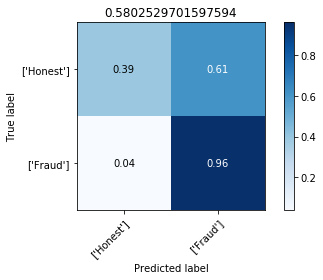

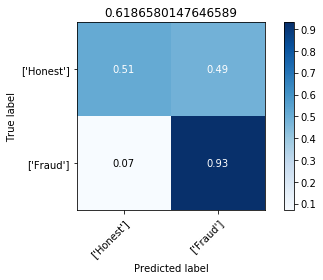

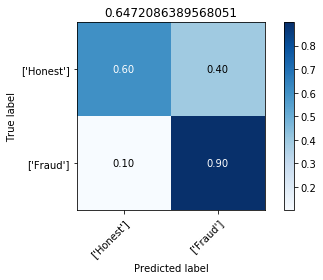

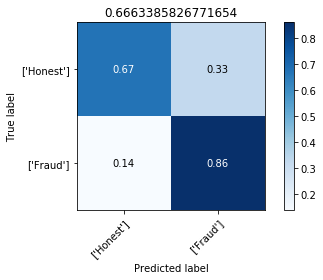

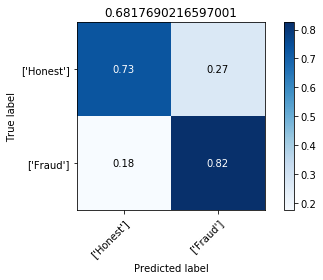

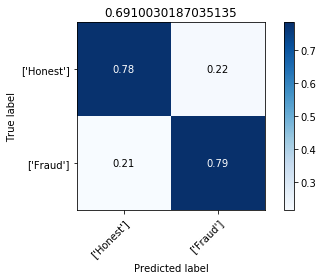

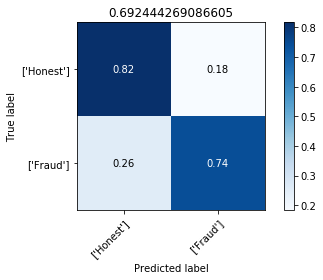

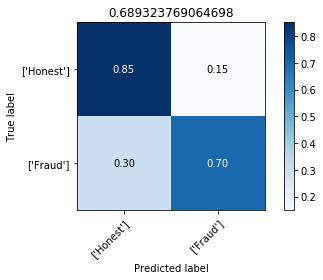

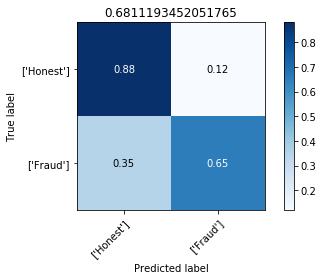

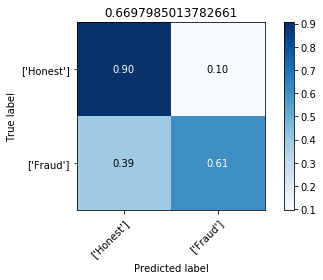

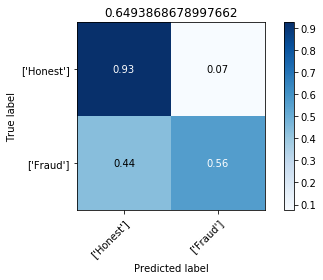

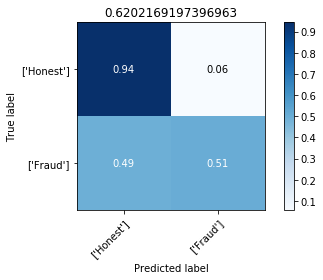

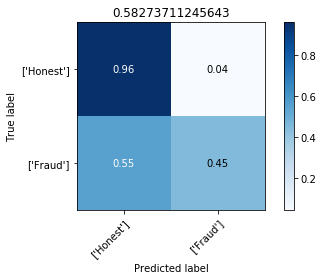

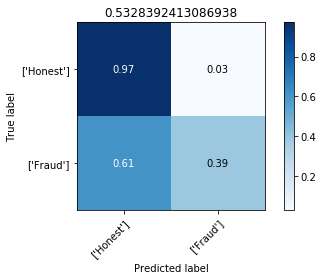

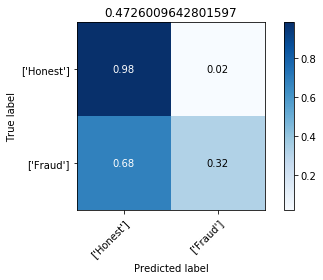

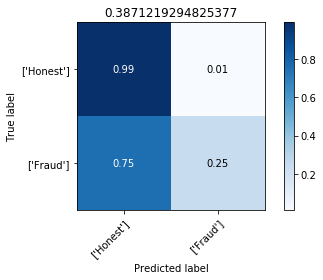

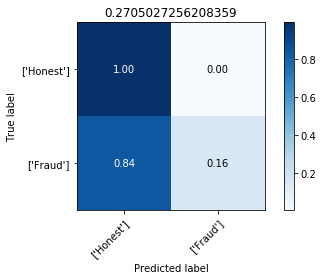

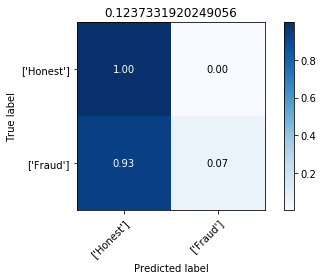

In [26]:
for i in range(len(yprob_m5)):
    plot_confusion_matrix(y_data[0], yprob_m5[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_m5[i],
                          cmap=plt.cm.Blues)

## Model 1

In [27]:
prob_m1 = np.ravel(model1.predict(x_data[0]))
precision_m1,recall_m1,f1_m1,yprob_m1 = choosing_threshold(y_data[0],prob_m1,threshold_list)

In [28]:
print('precision values: {}'.format(precision_m1))
print('recall values: {}'.format(recall_m1))
print('f1 values: {}'.format(f1_m1))

precision values: [0.4375204128290548, 0.4891411648568608, 0.5340554592720971, 0.5772529034154947, 0.6153293942238666, 0.6495079950799508, 0.6835713792865521, 0.7154892564538569, 0.7468134917194138, 0.776597836774828, 0.8048616556513947, 0.8293563781761899, 0.8562131073104283, 0.8762008337864782, 0.9023776863283036, 0.9253358325523274, 0.9526184538653366, 0.986198243412798]
recall values: [0.9474503147323007, 0.9111676921988825, 0.8717731098380367, 0.8331565174340476, 0.7881038262960606, 0.746941084942358, 0.7006860456892283, 0.6547139118749558, 0.6091661362189688, 0.5585967890232689, 0.5081688945469977, 0.4547704929627272, 0.40009901690359995, 0.34189122285875945, 0.27915694179220596, 0.20949147747365443, 0.13508734705424713, 0.055590918735412685]
f1 values: [0.5986102732533459, 0.6365590335252118, 0.6623498750638116, 0.6819892317489724, 0.6910816174646489, 0.6948254876805158, 0.6920229114277731, 0.6837537393359677, 0.671003427859146, 0.6498004854169237, 0.6229948842452094, 0.58742919

#### Above you can see the confusion matrix for all the thresholds

Normalized confusion matrix
[[0.45173819 0.54826181]
 [0.05254969 0.94745031]]
Normalized confusion matrix
[[0.57166051 0.42833949]
 [0.08883231 0.91116769]]
Normalized confusion matrix
[[0.65764676 0.34235324]
 [0.12822689 0.87177311]]
Normalized confusion matrix
[[0.72535974 0.27464026]
 [0.16684348 0.83315652]]
Normalized confusion matrix
[[0.77823762 0.22176238]
 [0.21189617 0.78810383]]
Normalized confusion matrix
[[0.81857252 0.18142748]
 [0.25305892 0.74694108]]
Normalized confusion matrix
[[0.85400484 0.14599516]
 [0.29931395 0.70068605]]
Normalized confusion matrix
[[0.88281548 0.11718452]
 [0.34528609 0.65471391]]
Normalized confusion matrix
[[0.90704189 0.09295811]
 [0.39083386 0.60916614]]
Normalized confusion matrix
[[0.92767095 0.07232905]
 [0.44140321 0.55859679]]
Normalized confusion matrix
[[0.94454349 0.05545651]
 [0.49183111 0.50816889]]
Normalized confusion matrix
[[0.95788234 0.04211766]
 [0.54522951 0.45477049]]
Normalized confusion matrix
[[0.96975678 0.03024322]

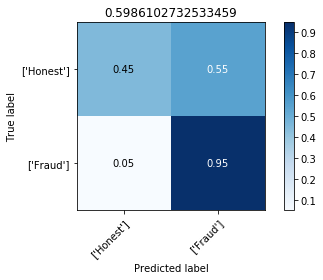

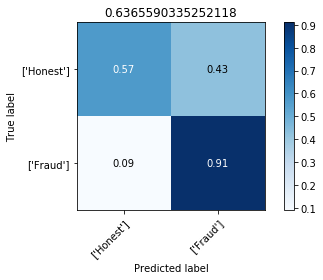

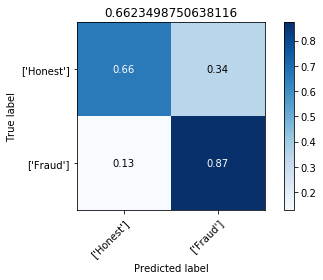

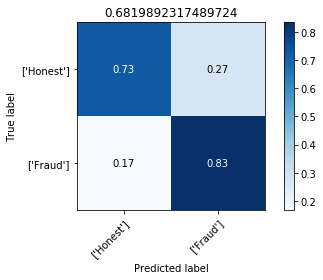

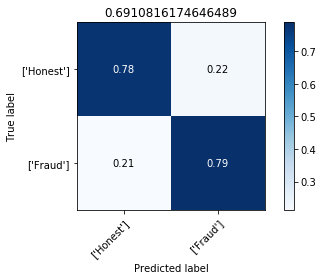

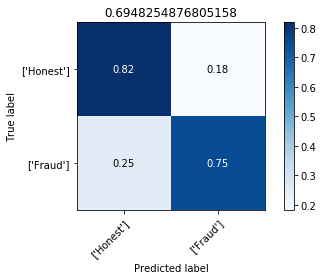

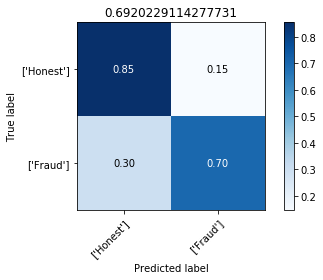

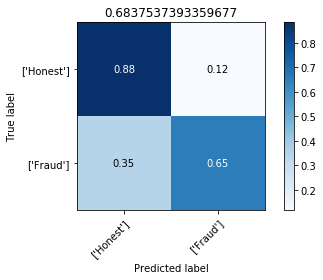

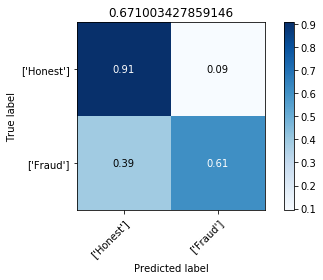

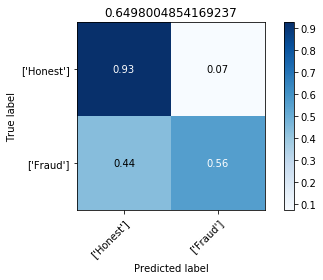

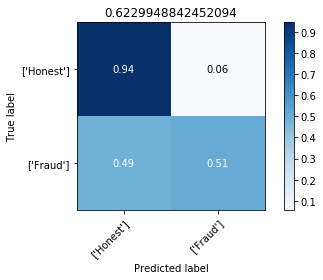

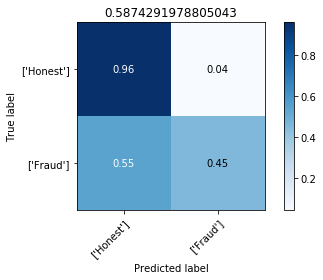

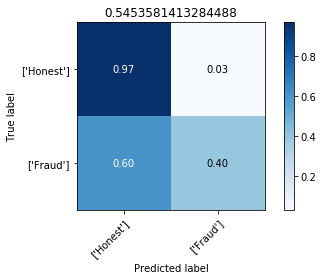

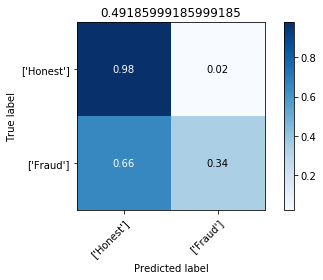

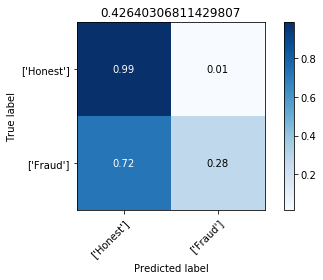

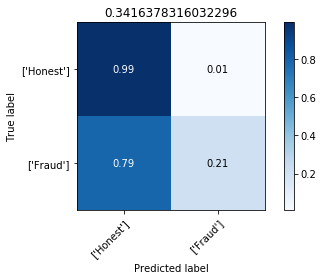

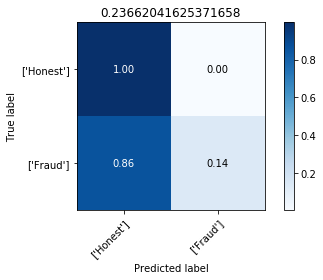

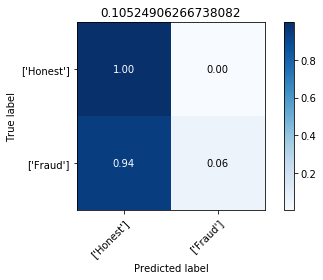

In [29]:
for i in range(len(yprob_m1)):
    plot_confusion_matrix(y_data[0], yprob_m1[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_m1[i],
                          cmap=plt.cm.Blues)

## Analysing the results of the precision, recall, f1 score and confusion matrix, we can see the recall is directed related to the anomaly detection and the precision to the non-anomaly detection.

## The summary of the results can be seen below, as you can see the model 5 is better predicting anomaly, model 3 is better predicting non-anomaly and model 1 has the best balanced performance.

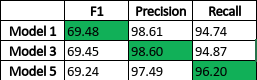




### Now we will choose the thresholds that are related to results in the table above and predict the train data.

In [30]:
y_hat_m3 = []
y_hat_m5 = []
y_hat_m1 = []

y_prob_m3 = []
y_prob_m5 = []
y_prob_m1 = []

In [31]:
def predict_threshold(y_prob,threshold):
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i]>threshold:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return y_hat

In [32]:
for i in range(len(x_data)):
    y_prob_m3.append(np.ravel(model3.predict(x_data[i])))
    y_hat_m3.append(predict_threshold(y_prob_m3[i],threshold_list[precision_m3.index(max(precision_m3 ))-1]))

for i in range(len(x_data)):
    y_prob_m5.append(np.ravel(model5.predict(x_data[i])))
    y_hat_m5.append(predict_threshold(y_prob_m5[i],threshold_list[recall_m5.index(max(recall_m5))])) 

for i in range(len(x_data)):
    y_prob_m1.append(np.ravel(model1.predict(x_data[i])))
    y_hat_m1.append(predict_threshold(y_prob_m1[i],threshold_list[f1_m1.index(max(f1_m1))]))

# Creating a new DataFrame, now we will study how the answers of the three algorithms work together

In [33]:
new_data = [np.vstack((y_hat_m1[0],y_prob_m1[0],y_hat_m3[0],y_prob_m3[0],y_hat_m5[0],y_prob_m5[0],y_train)).T,
         np.vstack((y_hat_m1[1],y_prob_m1[1],y_hat_m3[1],y_prob_m3[1],y_hat_m5[1],y_prob_m5[1],y_val)).T,
         np.vstack((y_hat_m1[2],y_prob_m1[2],y_hat_m3[2],y_prob_m3[2],y_hat_m5[2],y_prob_m5[2],y_test)).T] 

In [34]:
data_train = pd.DataFrame(data = new_data[0], columns = ['hat_m1','prob_m1','hat_m3','prob_m3','hat_m5','prob_m5','layer'])

## When the 3 algorithms agree?

- when all of them think that is a anomaly?
- when all of them think that is a non-anomaly?
- when the specialized models diverge, how the layers are distributed?

### All predictors says that is an anomaly

In [35]:
anomaly = []
non_anomaly = []

non_anomaly.append(data_train[(data_train.hat_m1 == 1) & (data_train.hat_m3 == 1) & (data_train.hat_m5 == 1) & (data_train.layer == 0)].count())
anomaly.append(data_train[(data_train.hat_m1 == 1) & (data_train.hat_m3 == 1) & (data_train.hat_m5 == 1) & (data_train.layer == 1)].count())

Text(0.5, 1.0, '2008')

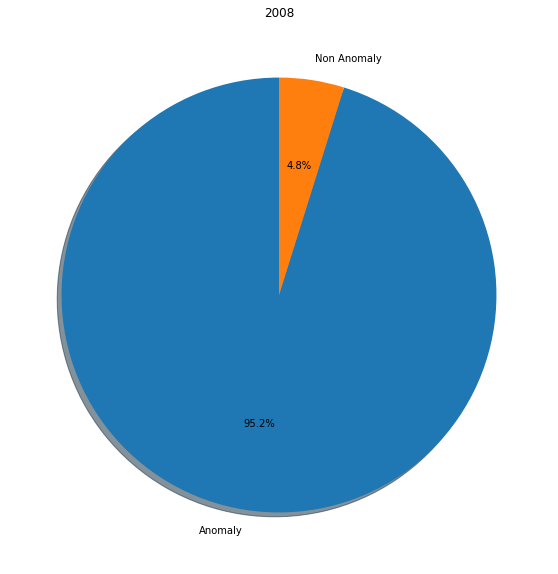

In [36]:
plt.rcParams["figure.figsize"] = (25,10)
plt.pie([anomaly[0]['layer'],non_anomaly[0]['layer']],
        labels= ['Anomaly','Non Anomaly'], 
        autopct= '%1.1f%%', shadow=True,startangle=90)
plt.title(anomaly[0]['layer']+non_anomaly[0]['layer'])

### All predictors says that is not an anomaly

In [37]:
non_anomaly.append(data_train[(data_train.hat_m1 == 0) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 0) & (data_train.layer == 0)].count())
anomaly.append(data_train[(data_train.hat_m1 == 0) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 0) & (data_train.layer == 1)].count())

Text(0.5, 1.0, '12807')

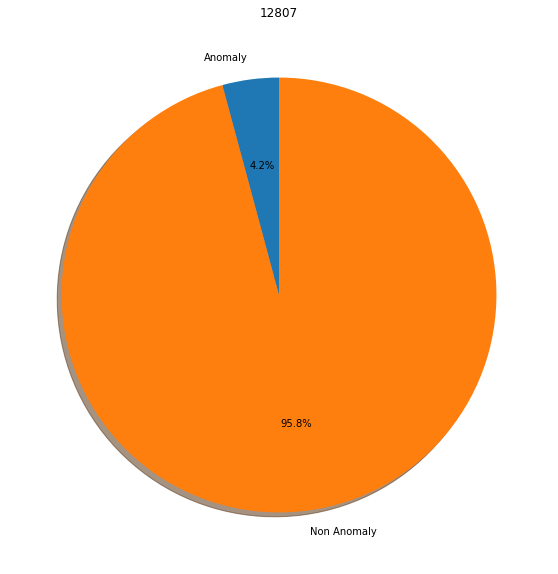

In [38]:
plt.pie([anomaly[1]['layer'],non_anomaly[1]['layer']],
        labels= ['Anomaly','Non Anomaly'], 
        autopct= '%1.1f%%', shadow=True,startangle=90)
plt.title(anomaly[1]['layer']+non_anomaly[1]['layer'])

### Sprecialized models desagree, but the balanced model says it's an anomaly

In [39]:
non_anomaly.append(data_train[(data_train.hat_m1 == 1) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 1) & (data_train.layer == 0)].count())
anomaly.append(data_train[(data_train.hat_m1 == 1) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 1) & (data_train.layer == 1)].count())

Text(0.5, 1.0, '14252')

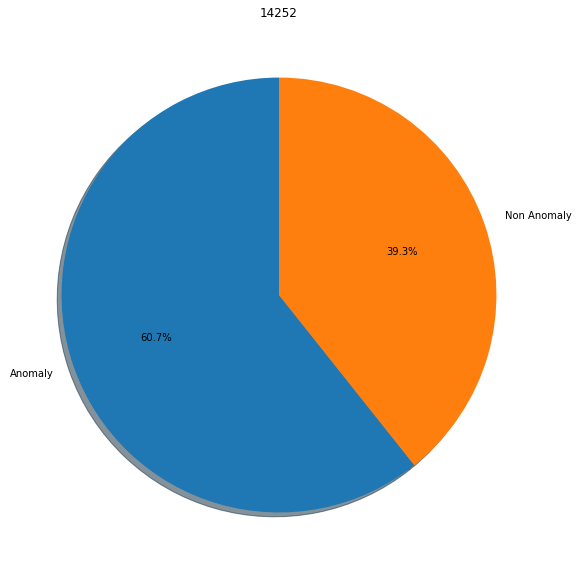

In [40]:
plt.pie([anomaly[2]['layer'],non_anomaly[2]['layer']],
        labels= ['Anomaly','Non Anomaly'], 
        autopct= '%1.1f%%', shadow=True,startangle=90)
plt.title(anomaly[2]['layer']+non_anomaly[2]['layer'])

### Sprecialized models desagree, but the balanced model says it is not an anomaly

In [41]:
non_anomaly.append(data_train[(data_train.hat_m1 == 0) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 1) & (data_train.layer == 0)].count())
anomaly.append(data_train[(data_train.hat_m1 == 0) & (data_train.hat_m3 == 0) & (data_train.hat_m5 == 1) & (data_train.layer == 1)].count())

Text(0.5, 1.0, '16484')

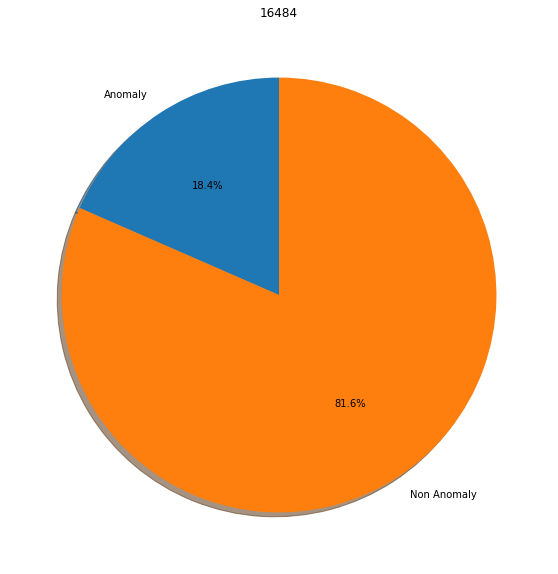

In [42]:
plt.pie([anomaly[3]['layer'],non_anomaly[3]['layer']],
        labels= ['Anomaly','Non Anomaly'], 
        autopct= '%1.1f%%', shadow=True,startangle=90)
plt.title(anomaly[3]['layer']+non_anomaly[3]['layer'])

In [43]:
"Cleaning the variable that we will not use more"
data_train = None
anomaly = None
non_anomaly = None
precision_m1 = None
recall_m1 = None
f1_m1 = None
yprob_m1 = None
precision_m3 = None
recall_m3 = None
f1_m3 = None
yprob_m3 = None
precision_m5 = None
recall_m5 = None
f1_m5 = None
yprob_m5 = None
prob_m5 = None
prob_m1 = None
prob_m3 = None

# Analysing the graphs above, we can take some decisions. When all the models agree we have an amazing performance (more them 95%), but when they desagree the performance it's very poor, in this case we can try to make the answers of these algorithms be a input to another one.

In [44]:
dataf = []
average = []
p0 = []
p1 = []
for i in range(len(new_data)):
    aux =  pd.DataFrame(data = new_data[i], columns = ['hat_m1','prob1_m1','hat_m3','prob1_m3','hat_m5','prob1_m5',
                                                       'layer'])
    average = pd.DataFrame(aux.iloc[:,[1,3,5]].mean(axis = 1, skipna = True),columns=['mean'])
    aux = aux.join(average.reset_index(drop=True))
    product = pd.DataFrame(np.sqrt(aux.iloc[:,[1,3,5]].prod(axis = 1, skipna = True))/
                           aux.iloc[:,[1,3,5]].sum(axis = 1, skipna = True),columns=['prod'])
    aux = aux.join(product.reset_index(drop=True))
    aux['prob0_m1'] = aux.iloc[:,1]
    aux['prob0_m3'] = 1 - aux.iloc[:,3]
    aux['prob0_m5'] = 1 - aux.iloc[:,5]                  
    aux['id'] = aux.index
    aux.set_index('id',inplace = True)
    aux = aux[['hat_m1','prob1_m1','prob0_m1','hat_m3','prob1_m3','prob0_m3',
               'hat_m5','prob1_m5','prob0_m5','prod','mean','layer']]
    p0.append(aux.loc[(aux['hat_m3']==0) & (aux['hat_m5']==0) & (aux['hat_m1'] ==0)])
    p1.append(aux.loc[(aux['hat_m3']==1) & (aux['hat_m5']==1) & (aux['hat_m1'] ==1)])
    aux =  aux.drop(p0[i].index)
    aux =  aux.drop(p1[i].index)
    dataf.append(aux)

In [45]:
dataf[0].head()

,hat_m1,prob1_m1,prob0_m1,hat_m3,prob1_m3,prob0_m3,hat_m5,prob1_m5,prob0_m5,prod,mean,layer
id,,,,,,,,,,,,
1,0.0,0.131278,0.131278,0.0,0.131740,0.868260,1.0,0.126287,0.873713,0.120045,0.129769,0.0
2,0.0,0.293125,0.293125,0.0,0.281910,0.718090,1.0,0.322745,0.677255,0.181904,0.299260,1.0
5,1.0,0.380657,0.380657,0.0,0.396283,0.603717,1.0,0.402749,0.597251,0.208939,0.393230,1.0
6,0.0,0.318431,0.318431,0.0,0.310970,0.689030,1.0,0.309341,0.690659,0.186440,0.312914,0.0
7,0.0,0.114744,0.114744,0.0,0.108351,0.891649,1.0,0.136143,0.863857,0.114524,0.119746,0.0


# Creating a Final Model, this model will try to learning "dataf", to achieve a better performance when the 3 past algorithm has fail

In [46]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (11,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [47]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 2s 56us/step - loss: 0.6329 - f1: 0.0000e+00 - val_loss: 0.6137 - val_f1: 0.0000e+00
Epoch 2/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.6028 - f1: 0.0464 - val_loss: 0.5926 - val_f1: 0.2285
Epoch 3/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5849 - f1: 0.4354 - val_loss: 0.5795 - val_f1: 0.5234
Epoch 4/500
30736/30736 [==============================] - 1s 42us/step - loss: 0.5731 - f1: 0.5737 - val_loss: 0.5709 - val_f1: 0.5921
Epoch 5/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5651 - f1: 0.6127 - val_loss: 0.5650 - val_f1: 0.6181
Epoch 6/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5595 - f1: 0.6304 - val_loss: 0.5609 - val_f1: 0.6272
Epoch 7/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5554 - f1: 0.6360 - val_loss: 0.5579 - val_f1

Epoch 120/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5315 - f1: 0.6242 - val_loss: 0.5392 - val_f1: 0.6139
Epoch 121/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5315 - f1: 0.6230 - val_loss: 0.5392 - val_f1: 0.6157
Epoch 122/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5315 - f1: 0.6238 - val_loss: 0.5393 - val_f1: 0.6166
Epoch 123/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5315 - f1: 0.6246 - val_loss: 0.5392 - val_f1: 0.6144
Epoch 124/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5314 - f1: 0.6232 - val_loss: 0.5391 - val_f1: 0.6141
Epoch 125/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5314 - f1: 0.6225 - val_loss: 0.5392 - val_f1: 0.6144
Epoch 126/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5314 - f1: 0.6250 - val_loss: 0.5391 - val_f1: 0.6145
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6257 - val_loss: 0.5386 - val_f1: 0.6125
Epoch 239/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5304 - f1: 0.6230 - val_loss: 0.5385 - val_f1: 0.6130
Epoch 240/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5305 - f1: 0.6213 - val_loss: 0.5385 - val_f1: 0.6131
Epoch 241/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5304 - f1: 0.6228 - val_loss: 0.5385 - val_f1: 0.6128
Epoch 242/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5304 - f1: 0.6229 - val_loss: 0.5385 - val_f1: 0.6125
Epoch 243/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6246 - val_loss: 0.5386 - val_f1: 0.6128
Epoch 244/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6232 - val_loss: 0.5385 - val_f1: 0.6130
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 2s 57us/step - loss: 0.5299 - f1: 0.6227 - val_loss: 0.5386 - val_f1: 0.6135
Epoch 357/500
30736/30736 [==============================] - 1s 43us/step - loss: 0.5299 - f1: 0.6220 - val_loss: 0.5386 - val_f1: 0.6136
Epoch 358/500
30736/30736 [==============================] - 1s 49us/step - loss: 0.5299 - f1: 0.6232 - val_loss: 0.5386 - val_f1: 0.6136
Epoch 359/500
30736/30736 [==============================] - 1s 45us/step - loss: 0.5299 - f1: 0.6225 - val_loss: 0.5385 - val_f1: 0.6124
Epoch 360/500
30736/30736 [==============================] - 1s 45us/step - loss: 0.5299 - f1: 0.6218 - val_loss: 0.5385 - val_f1: 0.6126
Epoch 361/500
30736/30736 [==============================] - 1s 48us/step - loss: 0.5299 - f1: 0.6219 - val_loss: 0.5387 - val_f1: 0.6134
Epoch 362/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5299 - f1: 0.6241 - val_loss: 0.5386 - val_f1: 0.6133
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 34us/step - loss: 0.5295 - f1: 0.6233 - val_loss: 0.5388 - val_f1: 0.6132
Epoch 475/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6208 - val_loss: 0.5388 - val_f1: 0.6136
Epoch 476/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6229 - val_loss: 0.5389 - val_f1: 0.6127
Epoch 477/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5295 - f1: 0.6232 - val_loss: 0.5389 - val_f1: 0.6127
Epoch 478/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6229 - val_loss: 0.5388 - val_f1: 0.6126
Epoch 479/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6236 - val_loss: 0.5387 - val_f1: 0.6101
Epoch 480/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5295 - f1: 0.6218 - val_loss: 0.5389 - val_f1: 0.6126
Epoch 481/500
30736/30736 [=====================

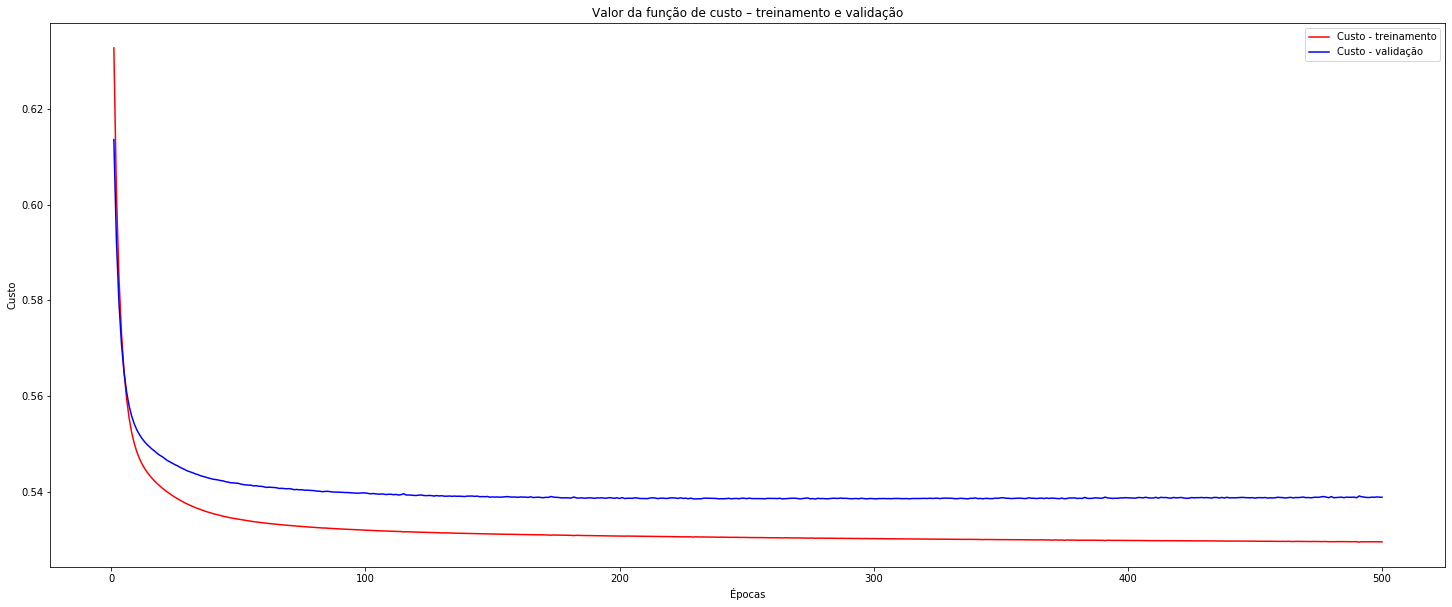

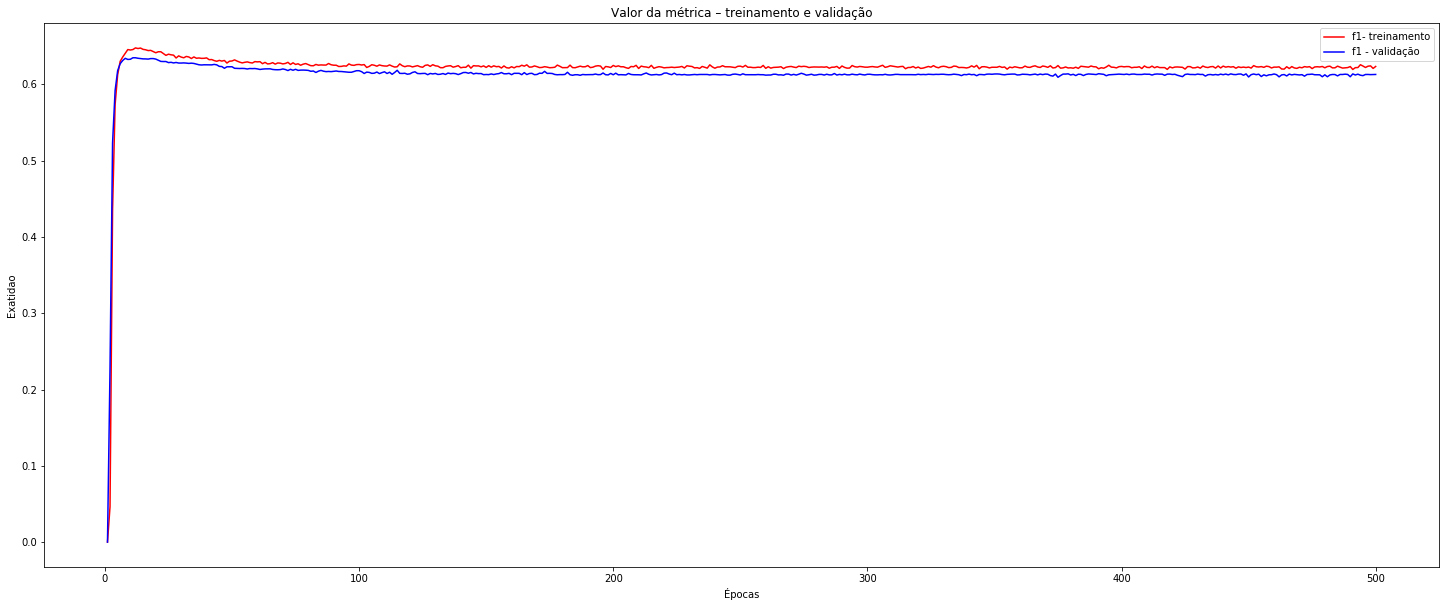

In [48]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [49]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model0.h5')

In [50]:
K.clear_session()

In [51]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (8,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 27        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [52]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.7748 - f1: 0.0016 - val_loss: 0.7252 - val_f1: 0.0000e+00
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6977 - f1: 0.0000e+00 - val_loss: 0.6657 - val_f1: 0.0000e+00
Epoch 3/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.6466 - f1: 0.0000e+00 - val_loss: 0.6261 - val_f1: 0.0000e+00
Epoch 4/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.6115 - f1: 0.1130 - val_loss: 0.5985 - val_f1: 0.3548
Epoch 5/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5865 - f1: 0.4699 - val_loss: 0.5790 - val_f1: 0.5154
Epoch 6/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5687 - f1: 0.5576 - val_loss: 0.5655 - val_f1: 0.5596
Epoch 7/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5563 - f1: 0.5878 - val_loss: 0.5

Epoch 120/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5295 - f1: 0.6234 - val_loss: 0.5401 - val_f1: 0.6128
Epoch 121/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6246 - val_loss: 0.5402 - val_f1: 0.6127
Epoch 122/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6268 - val_loss: 0.5401 - val_f1: 0.6112
Epoch 123/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5295 - f1: 0.6254 - val_loss: 0.5401 - val_f1: 0.6122
Epoch 124/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5295 - f1: 0.6229 - val_loss: 0.5401 - val_f1: 0.6119
Epoch 125/500
30736/30736 [==============================] - 2s 58us/step - loss: 0.5295 - f1: 0.6249 - val_loss: 0.5402 - val_f1: 0.6117
Epoch 126/500
30736/30736 [==============================] - 1s 46us/step - loss: 0.5295 - f1: 0.6239 - val_loss: 0.5401 - val_f1: 0.6121
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6244 - val_loss: 0.5403 - val_f1: 0.6121
Epoch 239/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6251 - val_loss: 0.5402 - val_f1: 0.6111
Epoch 240/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6240 - val_loss: 0.5403 - val_f1: 0.6117
Epoch 241/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6254 - val_loss: 0.5402 - val_f1: 0.6111
Epoch 242/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6257 - val_loss: 0.5403 - val_f1: 0.6119
Epoch 243/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6257 - val_loss: 0.5403 - val_f1: 0.6112
Epoch 244/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5293 - f1: 0.6242 - val_loss: 0.5402 - val_f1: 0.6105
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 37us/step - loss: 0.5292 - f1: 0.6247 - val_loss: 0.5404 - val_f1: 0.6110
Epoch 357/500
30736/30736 [==============================] - 1s 35us/step - loss: 0.5292 - f1: 0.6240 - val_loss: 0.5405 - val_f1: 0.6125
Epoch 358/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5292 - f1: 0.6235 - val_loss: 0.5405 - val_f1: 0.6119
Epoch 359/500
30736/30736 [==============================] - 1s 35us/step - loss: 0.5292 - f1: 0.6240 - val_loss: 0.5404 - val_f1: 0.6111
Epoch 360/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.5292 - f1: 0.6236 - val_loss: 0.5405 - val_f1: 0.6121
Epoch 361/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5292 - f1: 0.6250 - val_loss: 0.5404 - val_f1: 0.6115
Epoch 362/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5292 - f1: 0.6233 - val_loss: 0.5404 - val_f1: 0.6111
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 27us/step - loss: 0.5291 - f1: 0.6240 - val_loss: 0.5406 - val_f1: 0.6113
Epoch 475/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6271 - val_loss: 0.5405 - val_f1: 0.6106
Epoch 476/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5291 - f1: 0.6233 - val_loss: 0.5405 - val_f1: 0.6109
Epoch 477/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6243 - val_loss: 0.5406 - val_f1: 0.6117
Epoch 478/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5291 - f1: 0.6243 - val_loss: 0.5407 - val_f1: 0.6139
Epoch 479/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5291 - f1: 0.6251 - val_loss: 0.5406 - val_f1: 0.6114
Epoch 480/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6241 - val_loss: 0.5406 - val_f1: 0.6120
Epoch 481/500
30736/30736 [=====================

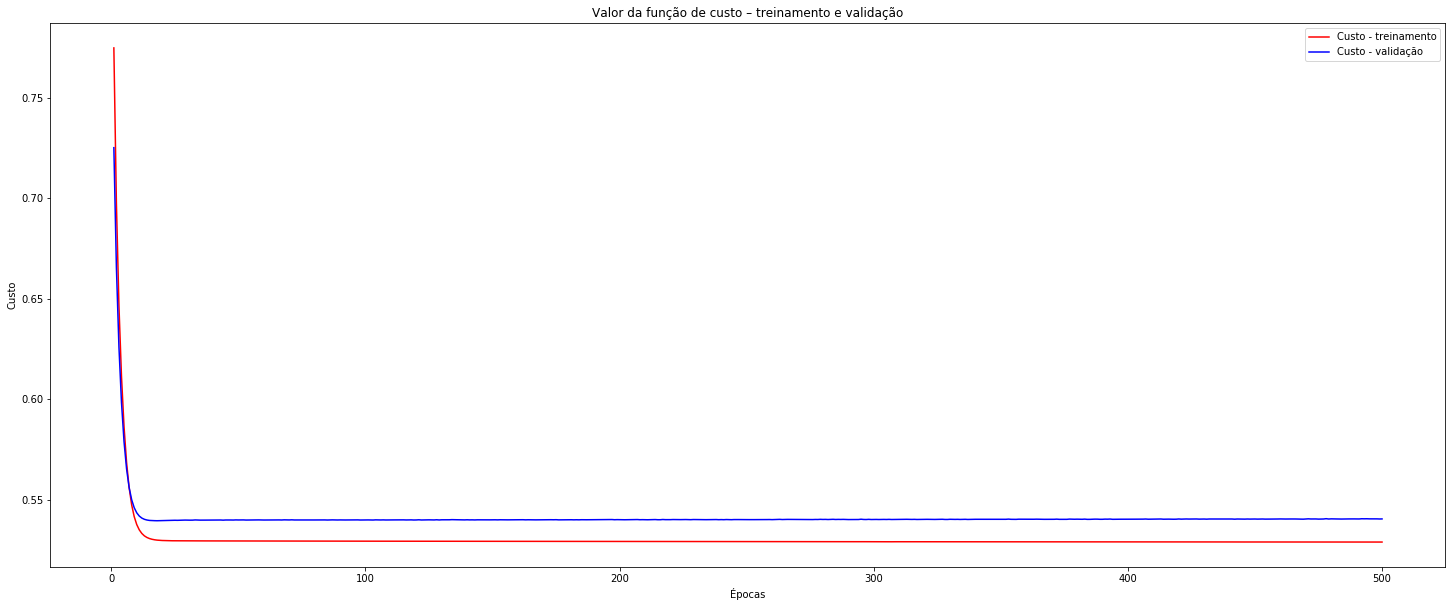

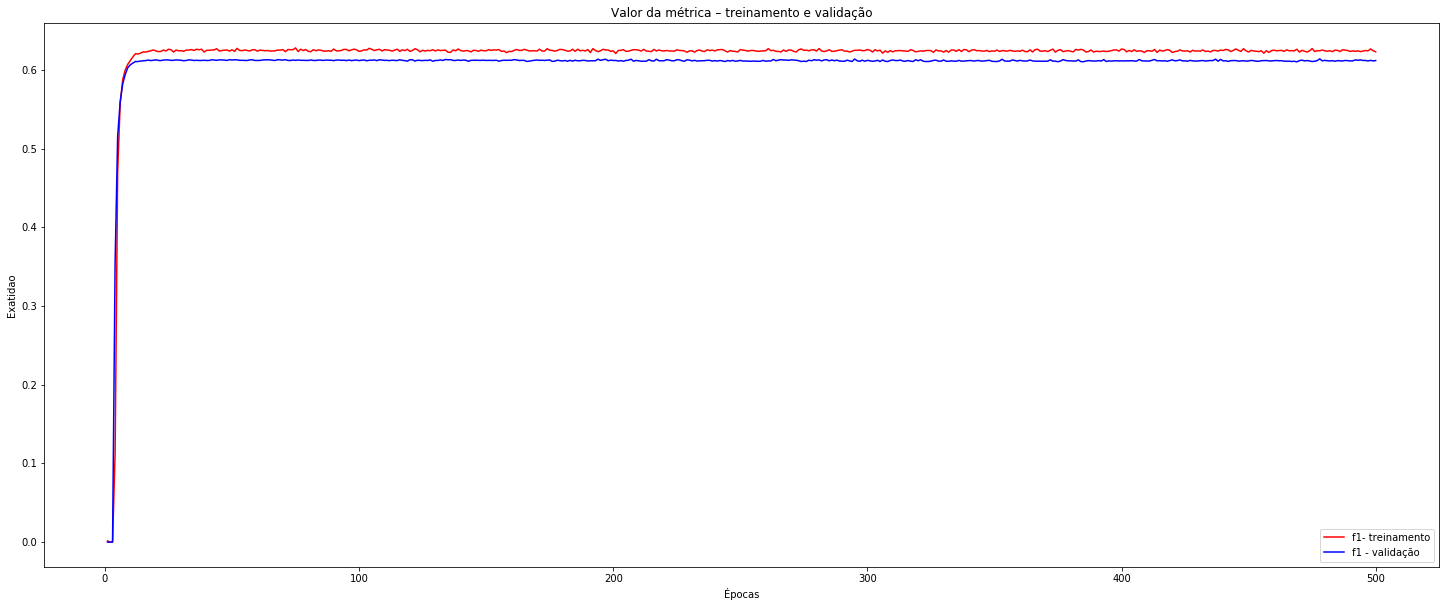

In [53]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [54]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model1.h5')

## Changing the hyperparameters, doubling the number od neurons

In [55]:
K.clear_session()

In [56]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (11,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [57]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.7628 - f1: 0.1223 - val_loss: 0.7127 - val_f1: 0.0000e+00
Epoch 2/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.6907 - f1: 0.0000e+00 - val_loss: 0.6654 - val_f1: 0.0000e+00
Epoch 3/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.6515 - f1: 0.0000e+00 - val_loss: 0.6351 - val_f1: 0.0000e+00
Epoch 4/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.6242 - f1: 0.0000e+00 - val_loss: 0.6127 - val_f1: 0.0000e+00
Epoch 5/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.6033 - f1: 0.1795 - val_loss: 0.5955 - val_f1: 0.3647
Epoch 6/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5870 - f1: 0.4684 - val_loss: 0.5822 - val_f1: 0.5195
Epoch 7/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5743 - f1: 0.5659 - val_l

Epoch 120/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5296 - f1: 0.6220 - val_loss: 0.5396 - val_f1: 0.6127
Epoch 121/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5296 - f1: 0.6222 - val_loss: 0.5396 - val_f1: 0.6115
Epoch 122/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5296 - f1: 0.6228 - val_loss: 0.5395 - val_f1: 0.6116
Epoch 123/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5296 - f1: 0.6236 - val_loss: 0.5395 - val_f1: 0.6097
Epoch 124/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5296 - f1: 0.6217 - val_loss: 0.5396 - val_f1: 0.6118
Epoch 125/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5296 - f1: 0.6218 - val_loss: 0.5395 - val_f1: 0.6103
Epoch 126/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5296 - f1: 0.6207 - val_loss: 0.5396 - val_f1: 0.6115
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 39us/step - loss: 0.5290 - f1: 0.6192 - val_loss: 0.5394 - val_f1: 0.6114
Epoch 239/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.5290 - f1: 0.6207 - val_loss: 0.5394 - val_f1: 0.6099
Epoch 240/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5290 - f1: 0.6223 - val_loss: 0.5394 - val_f1: 0.6099
Epoch 241/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5290 - f1: 0.6216 - val_loss: 0.5393 - val_f1: 0.6105
Epoch 242/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5290 - f1: 0.6209 - val_loss: 0.5393 - val_f1: 0.6105
Epoch 243/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5290 - f1: 0.6212 - val_loss: 0.5393 - val_f1: 0.6099
Epoch 244/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5290 - f1: 0.6217 - val_loss: 0.5393 - val_f1: 0.6096
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5287 - f1: 0.6201 - val_loss: 0.5394 - val_f1: 0.6101
Epoch 357/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5287 - f1: 0.6214 - val_loss: 0.5394 - val_f1: 0.6105
Epoch 358/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.5287 - f1: 0.6221 - val_loss: 0.5393 - val_f1: 0.6093
Epoch 359/500
30736/30736 [==============================] - 1s 35us/step - loss: 0.5287 - f1: 0.6219 - val_loss: 0.5393 - val_f1: 0.6094
Epoch 360/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5287 - f1: 0.6193 - val_loss: 0.5395 - val_f1: 0.6103
Epoch 361/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.5287 - f1: 0.6210 - val_loss: 0.5394 - val_f1: 0.6103
Epoch 362/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5287 - f1: 0.6195 - val_loss: 0.5395 - val_f1: 0.6105
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6222 - val_loss: 0.5396 - val_f1: 0.6096
Epoch 475/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6214 - val_loss: 0.5396 - val_f1: 0.6096
Epoch 476/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6194 - val_loss: 0.5396 - val_f1: 0.6096
Epoch 477/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6208 - val_loss: 0.5396 - val_f1: 0.6100
Epoch 478/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6190 - val_loss: 0.5395 - val_f1: 0.6090
Epoch 479/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6188 - val_loss: 0.5396 - val_f1: 0.6102
Epoch 480/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5285 - f1: 0.6198 - val_loss: 0.5397 - val_f1: 0.6103
Epoch 481/500
30736/30736 [=====================

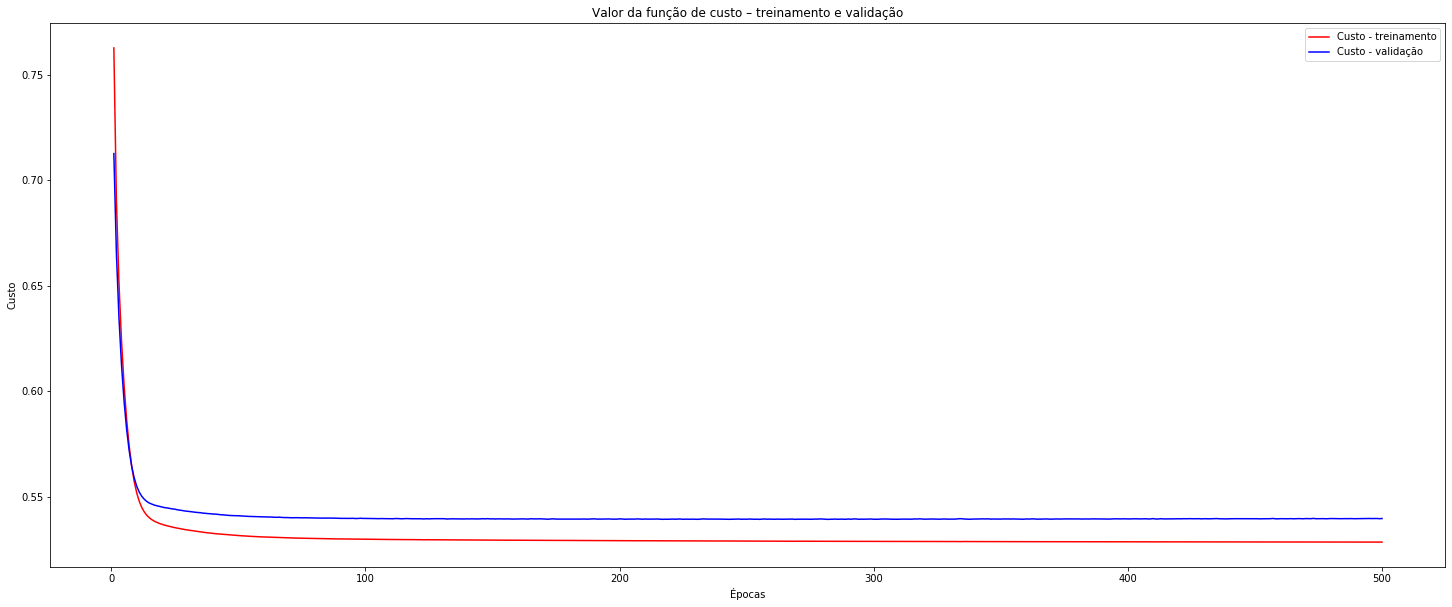

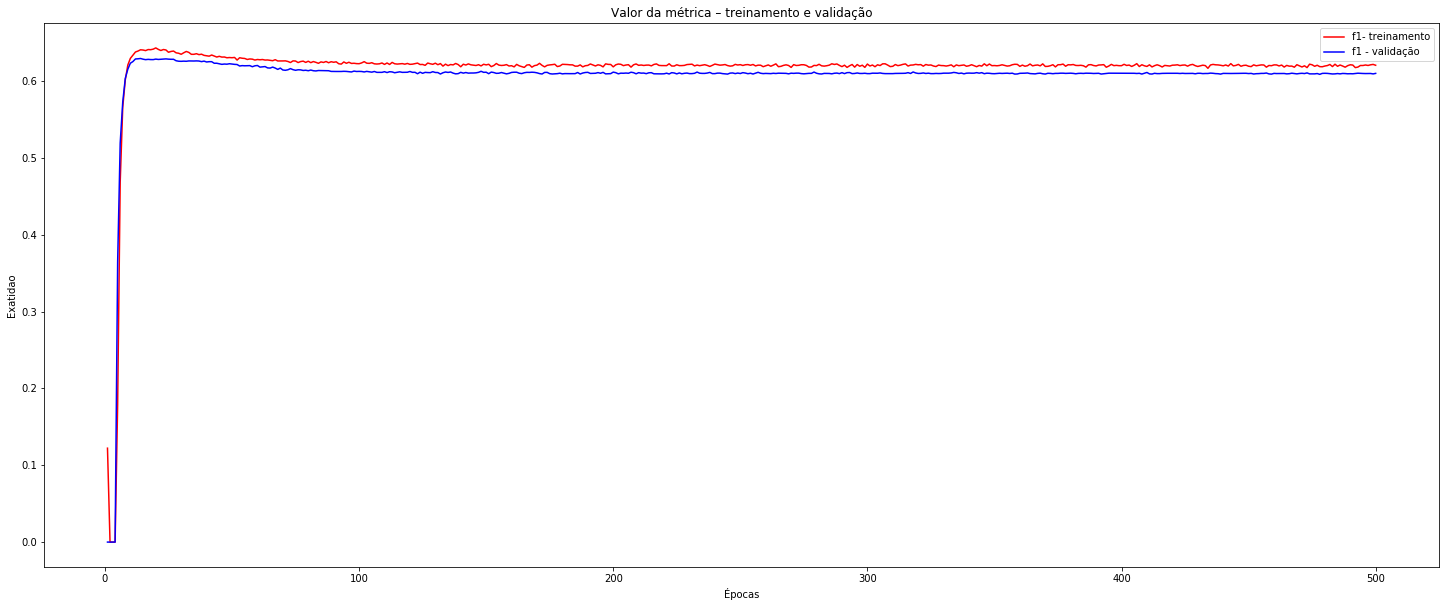

In [58]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [59]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model2.h5')

In [60]:
K.clear_session()

In [61]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (8,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 27        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [62]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5827 - f1: 0.5926 - val_loss: 0.5774 - val_f1: 0.5598
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5676 - f1: 0.5717 - val_loss: 0.5660 - val_f1: 0.5593
Epoch 3/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5571 - f1: 0.5827 - val_loss: 0.5577 - val_f1: 0.5709
Epoch 4/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5492 - f1: 0.5896 - val_loss: 0.5517 - val_f1: 0.5841
Epoch 5/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5434 - f1: 0.5972 - val_loss: 0.5475 - val_f1: 0.5943
Epoch 6/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5392 - f1: 0.6051 - val_loss: 0.5446 - val_f1: 0.5973
Epoch 7/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5362 - f1: 0.6084 - val_loss: 0.5428 - val_f1: 0.6024

Epoch 120/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6250 - val_loss: 0.5401 - val_f1: 0.6113
Epoch 121/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6255 - val_loss: 0.5401 - val_f1: 0.6117
Epoch 122/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6237 - val_loss: 0.5401 - val_f1: 0.6112
Epoch 123/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6256 - val_loss: 0.5400 - val_f1: 0.6121
Epoch 124/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5295 - f1: 0.6241 - val_loss: 0.5401 - val_f1: 0.6115
Epoch 125/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6250 - val_loss: 0.5401 - val_f1: 0.6111
Epoch 126/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5295 - f1: 0.6239 - val_loss: 0.5401 - val_f1: 0.6115
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 24us/step - loss: 0.5293 - f1: 0.6247 - val_loss: 0.5400 - val_f1: 0.6112
Epoch 239/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5293 - f1: 0.6245 - val_loss: 0.5400 - val_f1: 0.6114
Epoch 240/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5293 - f1: 0.6260 - val_loss: 0.5400 - val_f1: 0.6112
Epoch 241/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5293 - f1: 0.6244 - val_loss: 0.5401 - val_f1: 0.6124
Epoch 242/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5293 - f1: 0.6239 - val_loss: 0.5401 - val_f1: 0.6125
Epoch 243/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5293 - f1: 0.6252 - val_loss: 0.5400 - val_f1: 0.6122
Epoch 244/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5293 - f1: 0.6234 - val_loss: 0.5400 - val_f1: 0.6121
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6254 - val_loss: 0.5401 - val_f1: 0.6123
Epoch 357/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6261 - val_loss: 0.5400 - val_f1: 0.6116
Epoch 358/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5291 - f1: 0.6230 - val_loss: 0.5401 - val_f1: 0.6118
Epoch 359/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6249 - val_loss: 0.5400 - val_f1: 0.6118
Epoch 360/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6265 - val_loss: 0.5400 - val_f1: 0.6104
Epoch 361/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5291 - f1: 0.6239 - val_loss: 0.5400 - val_f1: 0.6112
Epoch 362/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.5291 - f1: 0.6247 - val_loss: 0.5400 - val_f1: 0.6118
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 25us/step - loss: 0.5290 - f1: 0.6259 - val_loss: 0.5400 - val_f1: 0.6114
Epoch 475/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5290 - f1: 0.6226 - val_loss: 0.5400 - val_f1: 0.6112
Epoch 476/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.5290 - f1: 0.6234 - val_loss: 0.5401 - val_f1: 0.6122
Epoch 477/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5290 - f1: 0.6247 - val_loss: 0.5401 - val_f1: 0.6122
Epoch 478/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5290 - f1: 0.6253 - val_loss: 0.5400 - val_f1: 0.6110
Epoch 479/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5290 - f1: 0.6244 - val_loss: 0.5400 - val_f1: 0.6110
Epoch 480/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5290 - f1: 0.6245 - val_loss: 0.5400 - val_f1: 0.6112
Epoch 481/500
30736/30736 [=====================

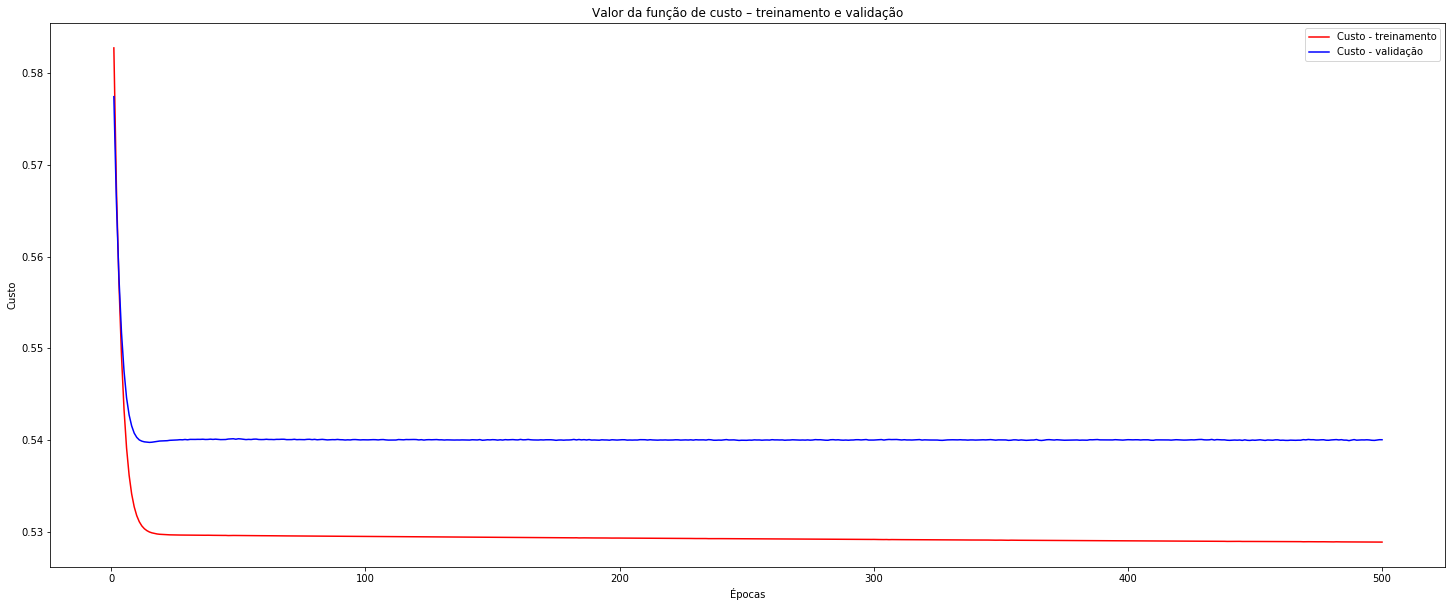

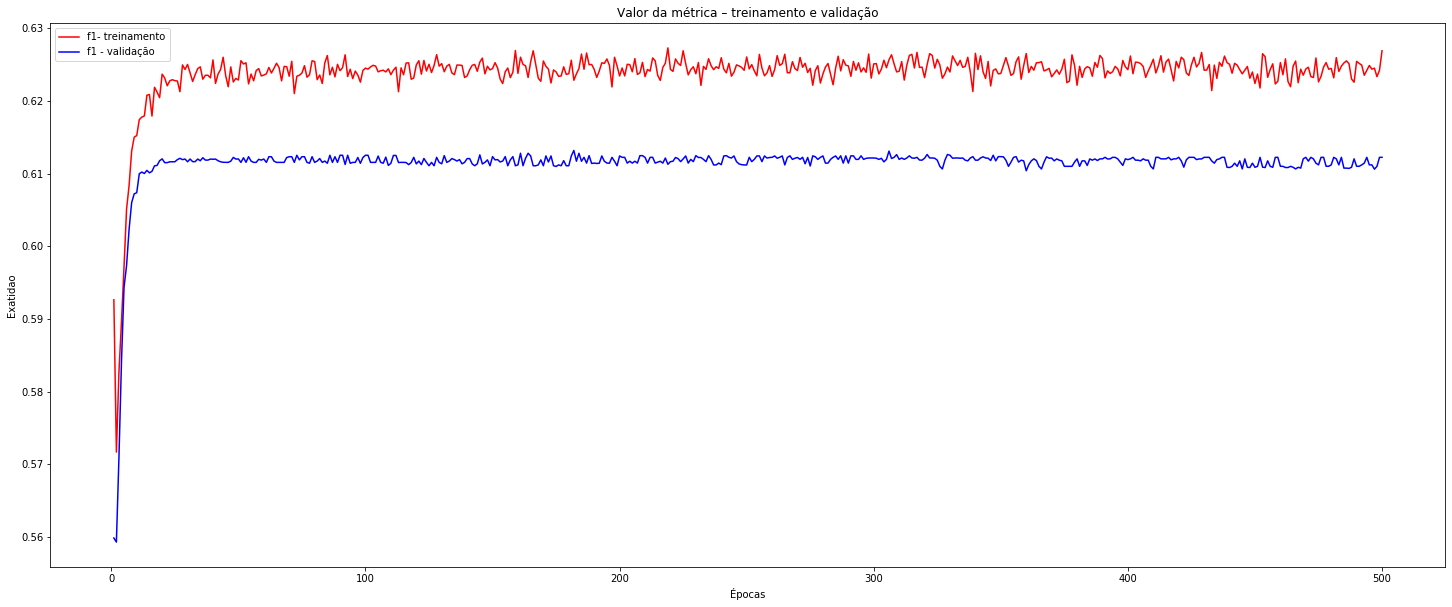

In [63]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [64]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model2.h5')

## Changing the hyperparameters, adding hidden layers

In [47]:
K.clear_session()

In [48]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (11,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 3,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 58
Non-trainable params: 6
_________________________________________________________________


In [49]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 2s 60us/step - loss: 0.5760 - f1: 0.6587 - val_loss: 0.5671 - val_f1: 0.6426
Epoch 2/500
30736/30736 [==============================] - 1s 43us/step - loss: 0.5515 - f1: 0.6561 - val_loss: 0.5546 - val_f1: 0.6448
Epoch 3/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.5430 - f1: 0.6505 - val_loss: 0.5478 - val_f1: 0.6371
Epoch 4/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5380 - f1: 0.6460 - val_loss: 0.5445 - val_f1: 0.6280
Epoch 5/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5357 - f1: 0.6379 - val_loss: 0.5426 - val_f1: 0.6244
Epoch 6/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5343 - f1: 0.6327 - val_loss: 0.5411 - val_f1: 0.6219
Epoch 7/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5335 - f1: 0.6293 - val_loss: 0.5405 - val_f1: 0.6186

Epoch 120/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5305 - f1: 0.6071 - val_loss: 0.5420 - val_f1: 0.5902
Epoch 121/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5300 - f1: 0.6095 - val_loss: 0.5418 - val_f1: 0.5879
Epoch 122/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5303 - f1: 0.6042 - val_loss: 0.5422 - val_f1: 0.5926
Epoch 123/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5302 - f1: 0.6048 - val_loss: 0.5425 - val_f1: 0.5970
Epoch 124/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5301 - f1: 0.6046 - val_loss: 0.5421 - val_f1: 0.5911
Epoch 125/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5296 - f1: 0.6090 - val_loss: 0.5418 - val_f1: 0.5790
Epoch 126/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5303 - f1: 0.6083 - val_loss: 0.5421 - val_f1: 0.5913
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 36us/step - loss: 0.5302 - f1: 0.6072 - val_loss: 0.5416 - val_f1: 0.5889
Epoch 239/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5298 - f1: 0.6072 - val_loss: 0.5425 - val_f1: 0.6004
Epoch 240/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5297 - f1: 0.6116 - val_loss: 0.5418 - val_f1: 0.5910
Epoch 241/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5298 - f1: 0.6095 - val_loss: 0.5420 - val_f1: 0.5929
Epoch 242/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5304 - f1: 0.6085 - val_loss: 0.5419 - val_f1: 0.5952
Epoch 243/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5304 - f1: 0.6079 - val_loss: 0.5416 - val_f1: 0.5897
Epoch 244/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5291 - f1: 0.6102 - val_loss: 0.5422 - val_f1: 0.5998
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 37us/step - loss: 0.5299 - f1: 0.6119 - val_loss: 0.5418 - val_f1: 0.5983
Epoch 357/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5301 - f1: 0.6116 - val_loss: 0.5421 - val_f1: 0.6013
Epoch 358/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5294 - f1: 0.6117 - val_loss: 0.5416 - val_f1: 0.5937
Epoch 359/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5298 - f1: 0.6085 - val_loss: 0.5417 - val_f1: 0.5976
Epoch 360/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5292 - f1: 0.6117 - val_loss: 0.5418 - val_f1: 0.5959
Epoch 361/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5300 - f1: 0.6093 - val_loss: 0.5418 - val_f1: 0.5933
Epoch 362/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5298 - f1: 0.6140 - val_loss: 0.5416 - val_f1: 0.5958
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 38us/step - loss: 0.5294 - f1: 0.6130 - val_loss: 0.5422 - val_f1: 0.6031
Epoch 475/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5296 - f1: 0.6134 - val_loss: 0.5418 - val_f1: 0.5932
Epoch 476/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5290 - f1: 0.6119 - val_loss: 0.5415 - val_f1: 0.5929
Epoch 477/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5289 - f1: 0.6122 - val_loss: 0.5413 - val_f1: 0.5900
Epoch 478/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5294 - f1: 0.6106 - val_loss: 0.5417 - val_f1: 0.5949
Epoch 479/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5292 - f1: 0.6112 - val_loss: 0.5419 - val_f1: 0.5991
Epoch 480/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5299 - f1: 0.6111 - val_loss: 0.5414 - val_f1: 0.5924
Epoch 481/500
30736/30736 [=====================

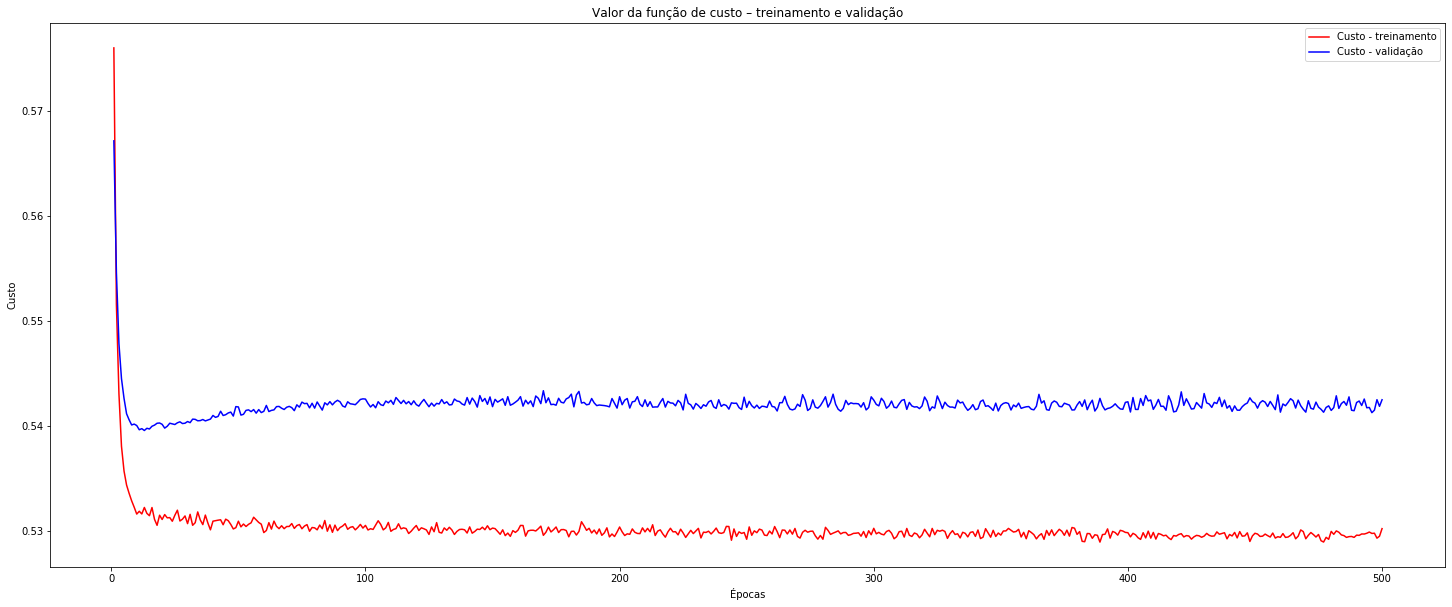

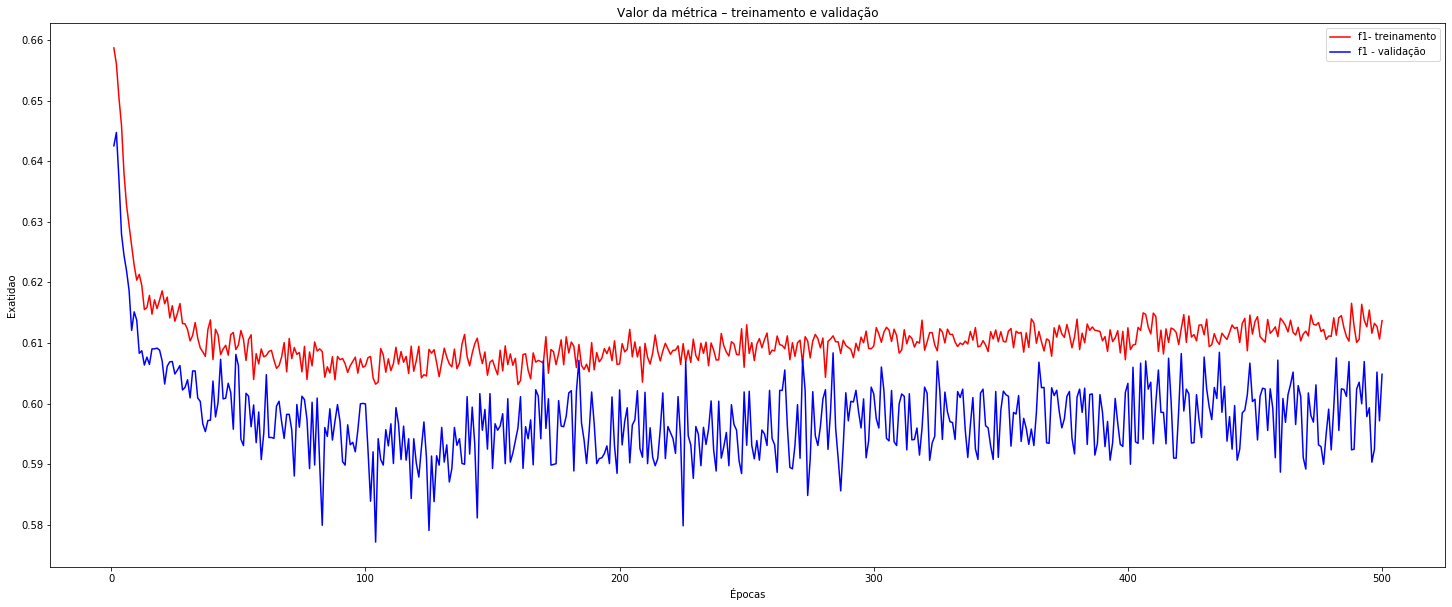

In [50]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [51]:
K.clear_session()

In [52]:
modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (8,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 6,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 115
Non-trainable params: 12
_________________________________________________________________


In [53]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 48us/step - loss: 0.5710 - f1: 0.6557 - val_loss: 0.5569 - val_f1: 0.6393
Epoch 2/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5479 - f1: 0.6493 - val_loss: 0.5484 - val_f1: 0.6335
Epoch 3/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5437 - f1: 0.6416 - val_loss: 0.5458 - val_f1: 0.6287
Epoch 4/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5401 - f1: 0.6415 - val_loss: 0.5446 - val_f1: 0.6250
Epoch 5/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5402 - f1: 0.6400 - val_loss: 0.5440 - val_f1: 0.6242
Epoch 6/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5394 - f1: 0.6393 - val_loss: 0.5439 - val_f1: 0.6235
Epoch 7/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.5394 - f1: 0.6357 - val_loss: 0.5437 - val_f1: 0.6242

Epoch 120/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5335 - f1: 0.6245 - val_loss: 0.5438 - val_f1: 0.6120
Epoch 121/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5327 - f1: 0.6279 - val_loss: 0.5429 - val_f1: 0.6110
Epoch 122/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5335 - f1: 0.6249 - val_loss: 0.5432 - val_f1: 0.6114
Epoch 123/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5340 - f1: 0.6231 - val_loss: 0.5426 - val_f1: 0.6050
Epoch 124/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5336 - f1: 0.6257 - val_loss: 0.5425 - val_f1: 0.6080
Epoch 125/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5334 - f1: 0.6254 - val_loss: 0.5423 - val_f1: 0.5991
Epoch 126/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5334 - f1: 0.6221 - val_loss: 0.5421 - val_f1: 0.6088
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 30us/step - loss: 0.5322 - f1: 0.6193 - val_loss: 0.5417 - val_f1: 0.6005
Epoch 239/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5323 - f1: 0.6194 - val_loss: 0.5439 - val_f1: 0.6161
Epoch 240/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5337 - f1: 0.6177 - val_loss: 0.5422 - val_f1: 0.6075
Epoch 241/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5330 - f1: 0.6199 - val_loss: 0.5421 - val_f1: 0.6003
Epoch 242/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5320 - f1: 0.6221 - val_loss: 0.5429 - val_f1: 0.6105
Epoch 243/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5330 - f1: 0.6197 - val_loss: 0.5418 - val_f1: 0.6044
Epoch 244/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5324 - f1: 0.6200 - val_loss: 0.5421 - val_f1: 0.6054
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5317 - f1: 0.6233 - val_loss: 0.5432 - val_f1: 0.6114
Epoch 357/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5330 - f1: 0.6152 - val_loss: 0.5434 - val_f1: 0.6097
Epoch 358/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5325 - f1: 0.6164 - val_loss: 0.5429 - val_f1: 0.6058
Epoch 359/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5321 - f1: 0.6191 - val_loss: 0.5415 - val_f1: 0.5966
Epoch 360/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5313 - f1: 0.6221 - val_loss: 0.5420 - val_f1: 0.6013
Epoch 361/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5325 - f1: 0.6212 - val_loss: 0.5436 - val_f1: 0.6122
Epoch 362/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5326 - f1: 0.6199 - val_loss: 0.5420 - val_f1: 0.6007
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5311 - f1: 0.6226 - val_loss: 0.5419 - val_f1: 0.5994
Epoch 475/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5312 - f1: 0.6176 - val_loss: 0.5431 - val_f1: 0.6069
Epoch 476/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5317 - f1: 0.6178 - val_loss: 0.5436 - val_f1: 0.6118
Epoch 477/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5322 - f1: 0.6185 - val_loss: 0.5440 - val_f1: 0.6117
Epoch 478/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5328 - f1: 0.6163 - val_loss: 0.5420 - val_f1: 0.6046
Epoch 479/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5322 - f1: 0.6157 - val_loss: 0.5439 - val_f1: 0.6115
Epoch 480/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5315 - f1: 0.6163 - val_loss: 0.5419 - val_f1: 0.5965
Epoch 481/500
30736/30736 [=====================

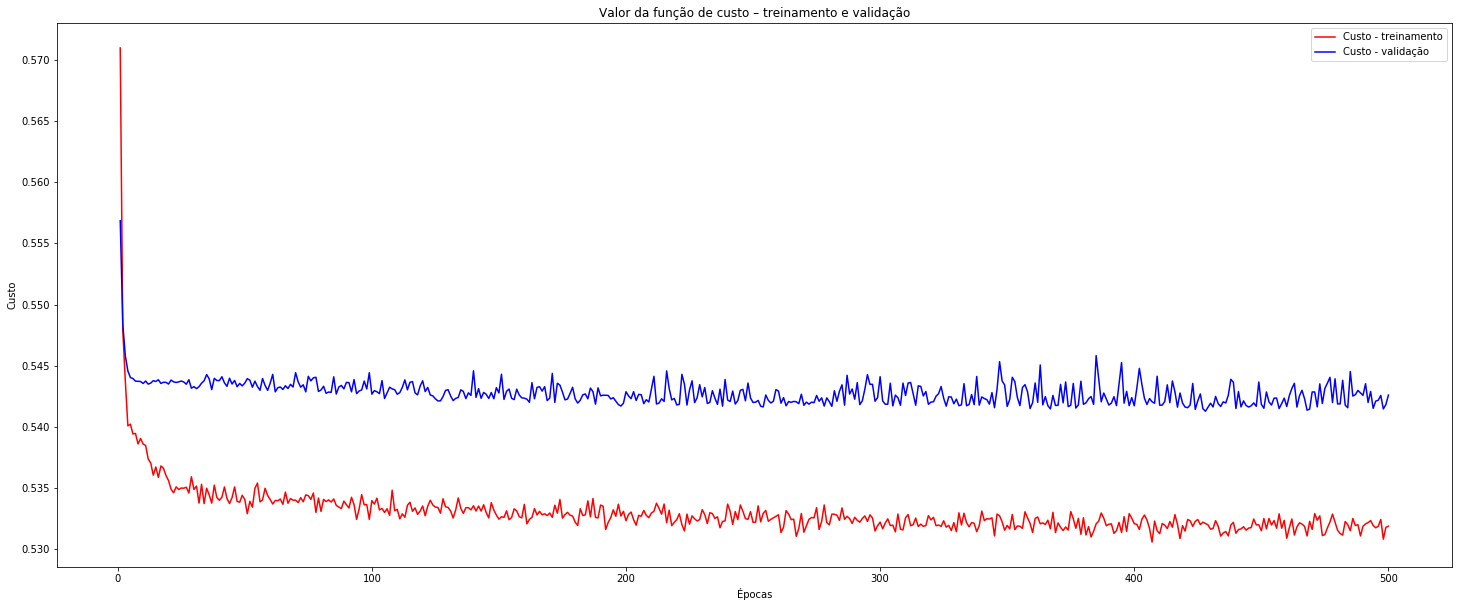

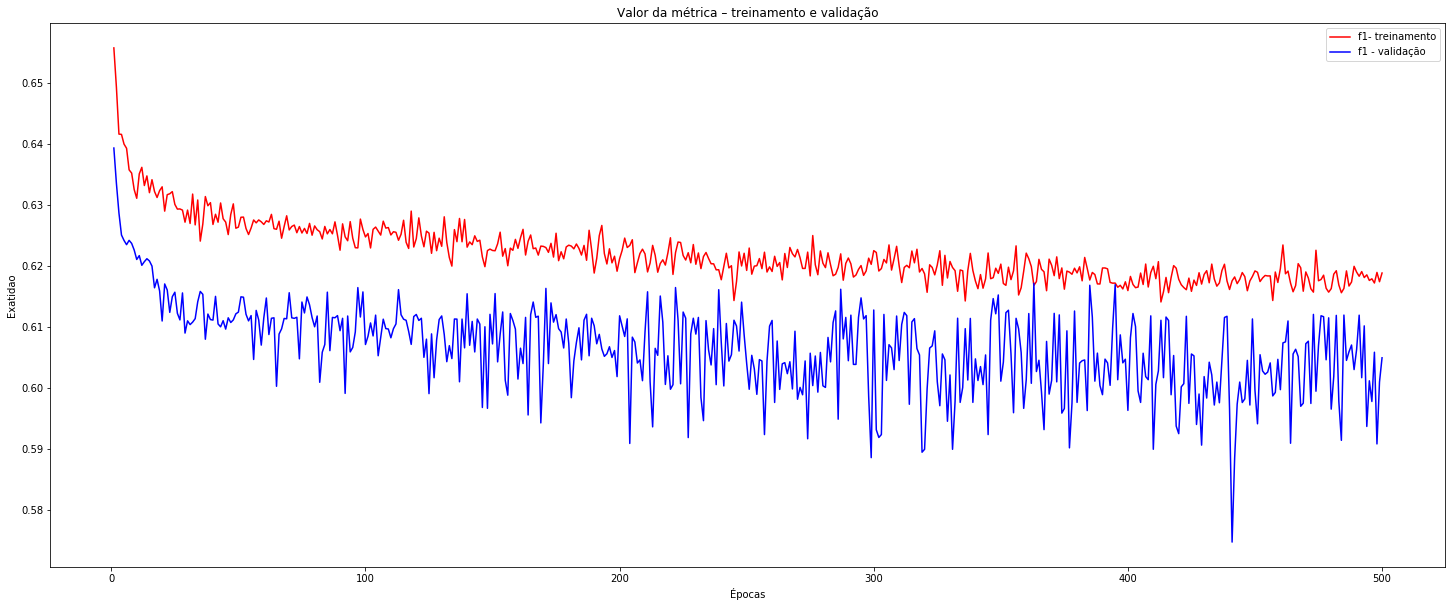

In [54]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

## Doing everything  again, but reducing the learning rate

In [65]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (11,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [66]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.8063 - f1: 0.2132 - val_loss: 0.7878 - val_f1: 0.2170
Epoch 2/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7772 - f1: 0.2101 - val_loss: 0.7619 - val_f1: 0.2170
Epoch 3/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.7544 - f1: 0.2102 - val_loss: 0.7416 - val_f1: 0.2170
Epoch 4/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7362 - f1: 0.2104 - val_loss: 0.7252 - val_f1: 0.2187
Epoch 5/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7214 - f1: 0.2080 - val_loss: 0.7118 - val_f1: 0.1930
Epoch 6/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7090 - f1: 0.1682 - val_loss: 0.7005 - val_f1: 0.1438
Epoch 7/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.6985 - f1: 0.1081 - val_loss: 0.6908 - val_f1: 0.0816

Epoch 120/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5295 - f1: 0.6207 - val_loss: 0.5399 - val_f1: 0.6088
Epoch 121/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5295 - f1: 0.6194 - val_loss: 0.5399 - val_f1: 0.6088
Epoch 122/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5295 - f1: 0.6205 - val_loss: 0.5399 - val_f1: 0.6091
Epoch 123/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5295 - f1: 0.6202 - val_loss: 0.5399 - val_f1: 0.6093
Epoch 124/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5294 - f1: 0.6199 - val_loss: 0.5399 - val_f1: 0.6093
Epoch 125/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5294 - f1: 0.6207 - val_loss: 0.5399 - val_f1: 0.6093
Epoch 126/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5294 - f1: 0.6213 - val_loss: 0.5399 - val_f1: 0.6093
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6220 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 239/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6213 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 240/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6209 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 241/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6211 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 242/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6192 - val_loss: 0.5402 - val_f1: 0.6106
Epoch 243/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6210 - val_loss: 0.5402 - val_f1: 0.6106
Epoch 244/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5292 - f1: 0.6221 - val_loss: 0.5402 - val_f1: 0.6106
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 31us/step - loss: 0.5291 - f1: 0.6197 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 357/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5291 - f1: 0.6213 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 358/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6230 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 359/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5291 - f1: 0.6222 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 360/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6209 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 361/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6219 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 362/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5291 - f1: 0.6218 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6226 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 475/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5291 - f1: 0.6204 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 476/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5291 - f1: 0.6220 - val_loss: 0.5402 - val_f1: 0.6104
Epoch 477/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5291 - f1: 0.6213 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 478/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6202 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 479/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5291 - f1: 0.6205 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 480/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5291 - f1: 0.6216 - val_loss: 0.5402 - val_f1: 0.6103
Epoch 481/500
30736/30736 [=====================

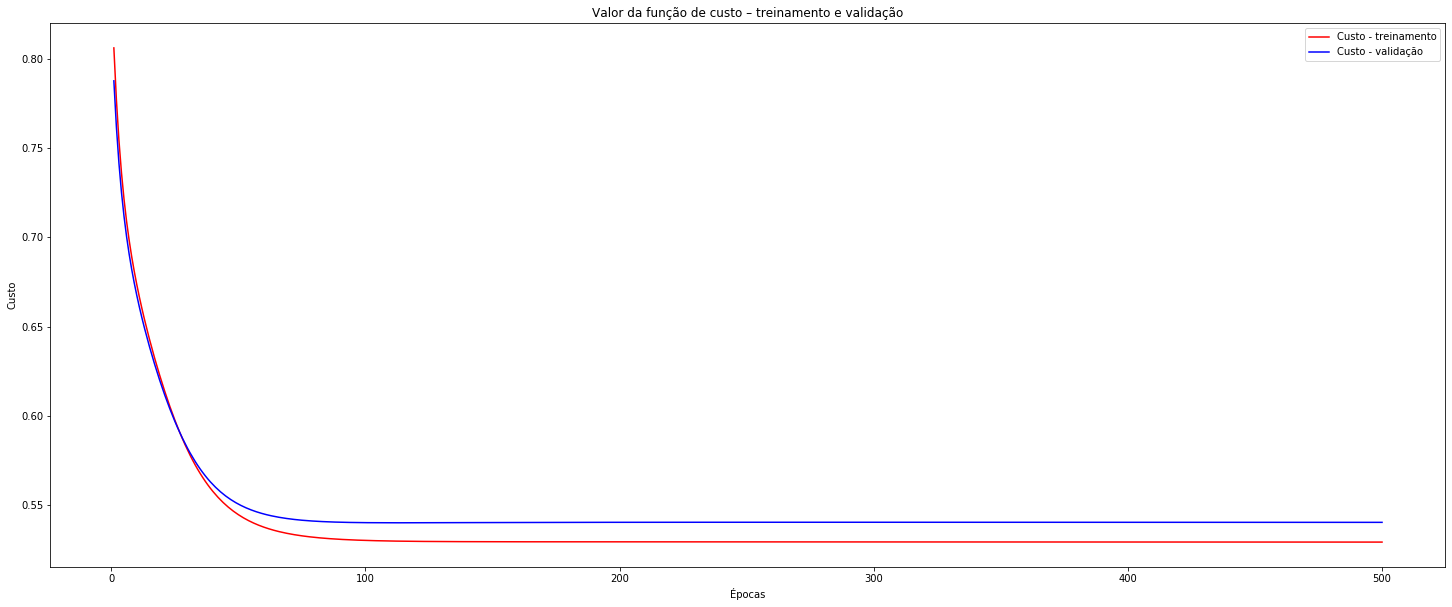

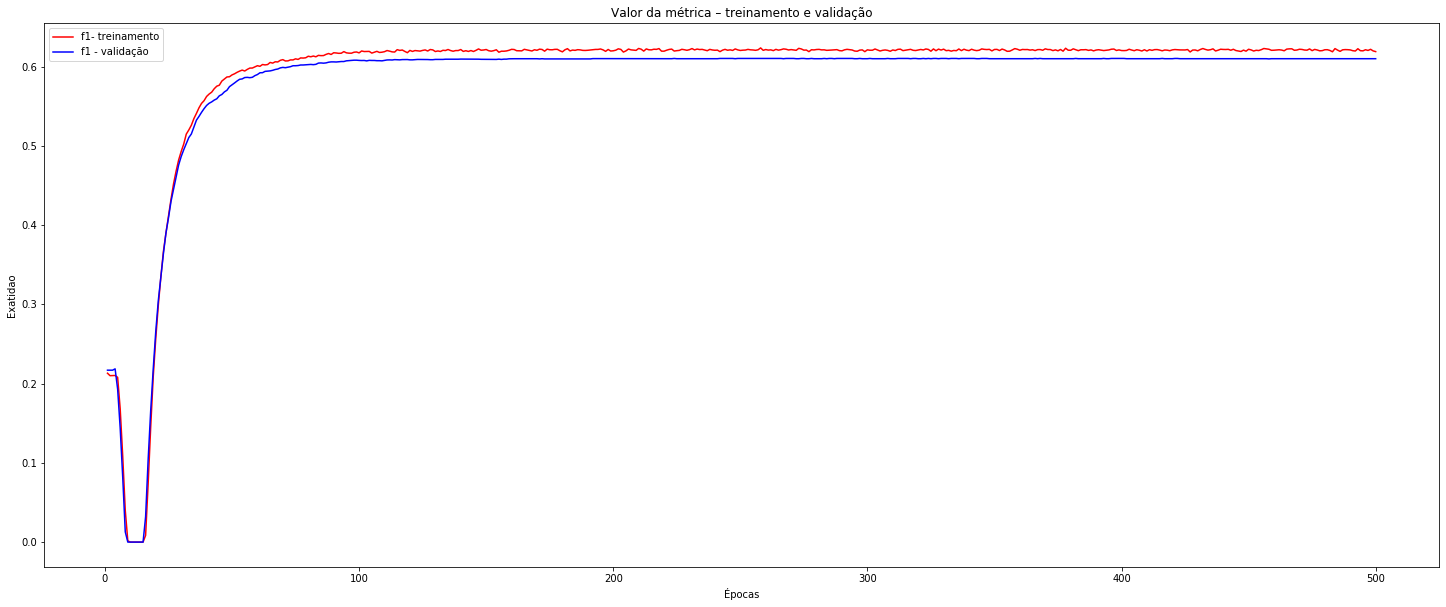

In [67]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [68]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model3.h5')

In [ ]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (8,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

In [53]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 42us/step - loss: 0.6463 - f1: 0.6518 - val_loss: 0.6433 - val_f1: 0.6387
Epoch 2/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.6388 - f1: 0.6413 - val_loss: 0.6362 - val_f1: 0.6279
Epoch 3/500
30736/30736 [==============================] - 1s 37us/step - loss: 0.6324 - f1: 0.6255 - val_loss: 0.6302 - val_f1: 0.6143
Epoch 4/500
30736/30736 [==============================] - 1s 35us/step - loss: 0.6269 - f1: 0.6101 - val_loss: 0.6251 - val_f1: 0.5951
Epoch 5/500
30736/30736 [==============================] - 1s 35us/step - loss: 0.6223 - f1: 0.5917 - val_loss: 0.6207 - val_f1: 0.5791
Epoch 6/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.6181 - f1: 0.5742 - val_loss: 0.6168 - val_f1: 0.5616
Epoch 7/500
30736/30736 [==============================] - 1s 40us/step - loss: 0.6145 - f1: 0.5624 - val_loss: 0.6133 - val_f1: 0.5503

Epoch 120/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5326 - f1: 0.6184 - val_loss: 0.5397 - val_f1: 0.6105
Epoch 121/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5325 - f1: 0.6169 - val_loss: 0.5397 - val_f1: 0.6105
Epoch 122/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5325 - f1: 0.6177 - val_loss: 0.5396 - val_f1: 0.6109
Epoch 123/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5324 - f1: 0.6192 - val_loss: 0.5396 - val_f1: 0.6109
Epoch 124/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5323 - f1: 0.6183 - val_loss: 0.5396 - val_f1: 0.6114
Epoch 125/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5323 - f1: 0.6205 - val_loss: 0.5395 - val_f1: 0.6112
Epoch 126/500
30736/30736 [==============================] - 1s 33us/step - loss: 0.5322 - f1: 0.6213 - val_loss: 0.5395 - val_f1: 0.6112
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 2s 54us/step - loss: 0.5305 - f1: 0.6252 - val_loss: 0.5390 - val_f1: 0.6138
Epoch 239/500
30736/30736 [==============================] - 1s 46us/step - loss: 0.5305 - f1: 0.6242 - val_loss: 0.5390 - val_f1: 0.6138
Epoch 240/500
30736/30736 [==============================] - 2s 52us/step - loss: 0.5305 - f1: 0.6245 - val_loss: 0.5390 - val_f1: 0.6138
Epoch 241/500
30736/30736 [==============================] - 1s 48us/step - loss: 0.5305 - f1: 0.6230 - val_loss: 0.5390 - val_f1: 0.6138
Epoch 242/500
30736/30736 [==============================] - 2s 54us/step - loss: 0.5305 - f1: 0.6230 - val_loss: 0.5390 - val_f1: 0.6138
Epoch 243/500
30736/30736 [==============================] - 2s 51us/step - loss: 0.5305 - f1: 0.6246 - val_loss: 0.5390 - val_f1: 0.6141
Epoch 244/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.5305 - f1: 0.6251 - val_loss: 0.5390 - val_f1: 0.6144
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 29us/step - loss: 0.5304 - f1: 0.6263 - val_loss: 0.5392 - val_f1: 0.6147
Epoch 357/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5304 - f1: 0.6244 - val_loss: 0.5392 - val_f1: 0.6147
Epoch 358/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5304 - f1: 0.6250 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 359/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5304 - f1: 0.6251 - val_loss: 0.5392 - val_f1: 0.6147
Epoch 360/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6250 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 361/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5304 - f1: 0.6275 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 362/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6256 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 29us/step - loss: 0.5304 - f1: 0.6245 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 475/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6252 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 476/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5304 - f1: 0.6258 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 477/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6253 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 478/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5304 - f1: 0.6247 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 479/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6257 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 480/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6265 - val_loss: 0.5392 - val_f1: 0.6145
Epoch 481/500
30736/30736 [=====================

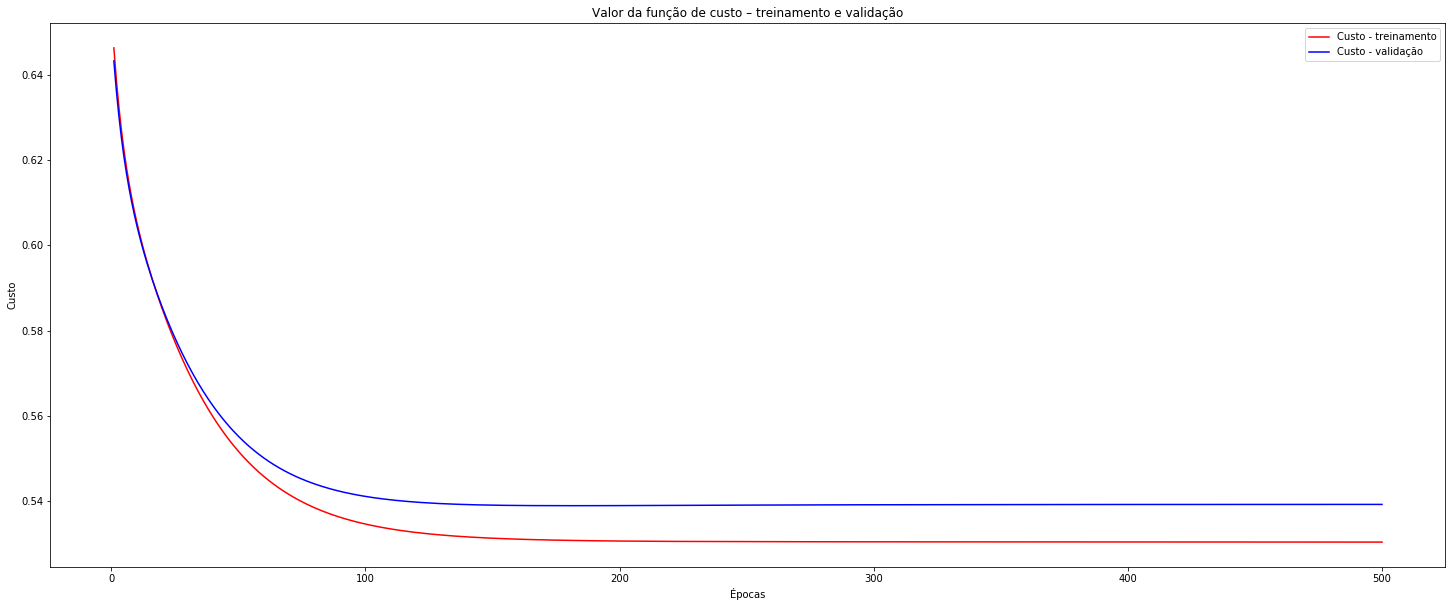

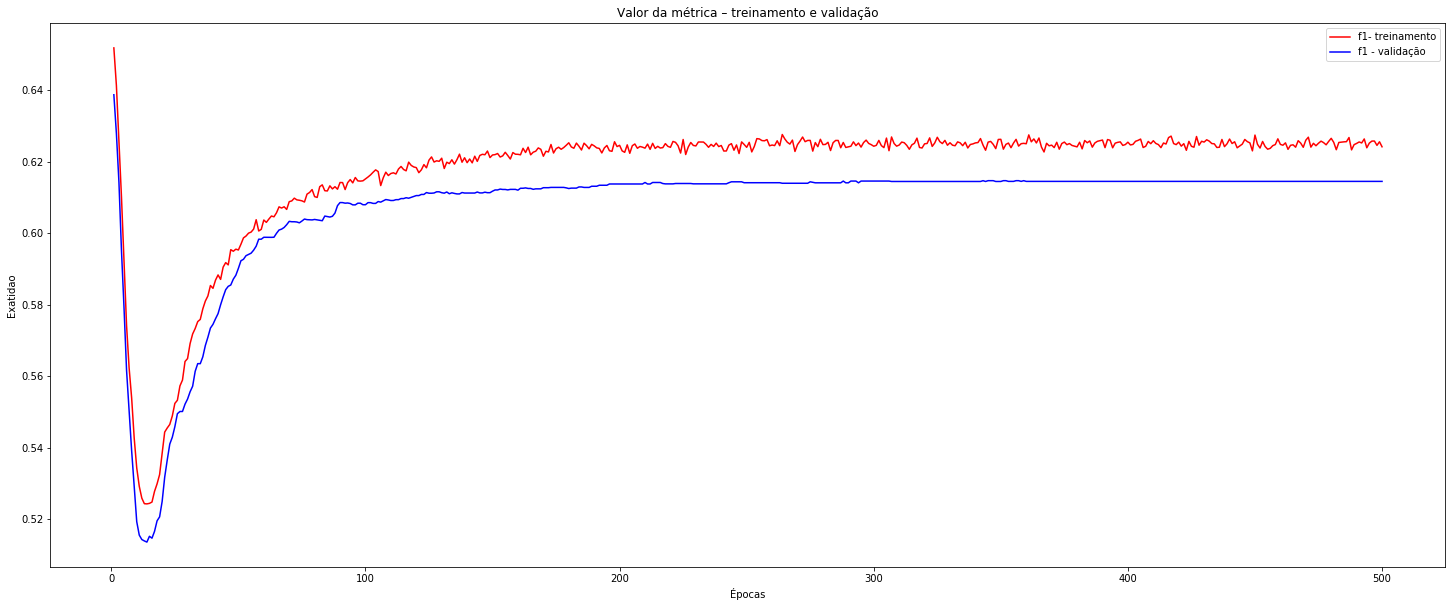

In [54]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [45]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (11,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [46]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 36us/step - loss: 1.0634 - f1: 0.5455 - val_loss: 1.0216 - val_f1: 0.5403
Epoch 2/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.9680 - f1: 0.5458 - val_loss: 0.9335 - val_f1: 0.5403
Epoch 3/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.8898 - f1: 0.5456 - val_loss: 0.8625 - val_f1: 0.5403
Epoch 4/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.8278 - f1: 0.5458 - val_loss: 0.8069 - val_f1: 0.5403
Epoch 5/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.7799 - f1: 0.5457 - val_loss: 0.7644 - val_f1: 0.5403
Epoch 6/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.7436 - f1: 0.5457 - val_loss: 0.7322 - val_f1: 0.5403
Epoch 7/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.7162 - f1: 0.5455 - val_loss: 0.7079 - val_f1: 0.5403

Epoch 120/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5335 - f1: 0.6327 - val_loss: 0.5431 - val_f1: 0.6212
Epoch 121/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5334 - f1: 0.6329 - val_loss: 0.5431 - val_f1: 0.6210
Epoch 122/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5333 - f1: 0.6317 - val_loss: 0.5431 - val_f1: 0.6209
Epoch 123/500
30736/30736 [==============================] - 1s 47us/step - loss: 0.5333 - f1: 0.6325 - val_loss: 0.5430 - val_f1: 0.6209
Epoch 124/500
30736/30736 [==============================] - 1s 47us/step - loss: 0.5332 - f1: 0.6326 - val_loss: 0.5430 - val_f1: 0.6209
Epoch 125/500
30736/30736 [==============================] - 1s 44us/step - loss: 0.5332 - f1: 0.6317 - val_loss: 0.5430 - val_f1: 0.6209
Epoch 126/500
30736/30736 [==============================] - 1s 39us/step - loss: 0.5331 - f1: 0.6338 - val_loss: 0.5430 - val_f1: 0.6209
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 45us/step - loss: 0.5311 - f1: 0.6303 - val_loss: 0.5419 - val_f1: 0.6195
Epoch 239/500
30736/30736 [==============================] - 1s 46us/step - loss: 0.5311 - f1: 0.6302 - val_loss: 0.5419 - val_f1: 0.6195
Epoch 240/500
30736/30736 [==============================] - 2s 59us/step - loss: 0.5311 - f1: 0.6292 - val_loss: 0.5419 - val_f1: 0.6197
Epoch 241/500
30736/30736 [==============================] - 1s 44us/step - loss: 0.5311 - f1: 0.6283 - val_loss: 0.5418 - val_f1: 0.6195
Epoch 242/500
30736/30736 [==============================] - 1s 38us/step - loss: 0.5311 - f1: 0.6287 - val_loss: 0.5418 - val_f1: 0.6195
Epoch 243/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5311 - f1: 0.6290 - val_loss: 0.5418 - val_f1: 0.6195
Epoch 244/500
30736/30736 [==============================] - 2s 49us/step - loss: 0.5311 - f1: 0.6307 - val_loss: 0.5418 - val_f1: 0.6195
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 28us/step - loss: 0.5303 - f1: 0.6271 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 357/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5303 - f1: 0.6286 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 358/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5303 - f1: 0.6280 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 359/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5303 - f1: 0.6279 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 360/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5303 - f1: 0.6287 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 361/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5303 - f1: 0.6272 - val_loss: 0.5412 - val_f1: 0.6176
Epoch 362/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5303 - f1: 0.6289 - val_loss: 0.5411 - val_f1: 0.6177
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 27us/step - loss: 0.5299 - f1: 0.6258 - val_loss: 0.5407 - val_f1: 0.6149
Epoch 475/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5299 - f1: 0.6260 - val_loss: 0.5407 - val_f1: 0.6150
Epoch 476/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5299 - f1: 0.6274 - val_loss: 0.5407 - val_f1: 0.6150
Epoch 477/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5299 - f1: 0.6258 - val_loss: 0.5407 - val_f1: 0.6147
Epoch 478/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5299 - f1: 0.6253 - val_loss: 0.5407 - val_f1: 0.6146
Epoch 479/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5299 - f1: 0.6263 - val_loss: 0.5407 - val_f1: 0.6146
Epoch 480/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5299 - f1: 0.6269 - val_loss: 0.5407 - val_f1: 0.6147
Epoch 481/500
30736/30736 [=====================

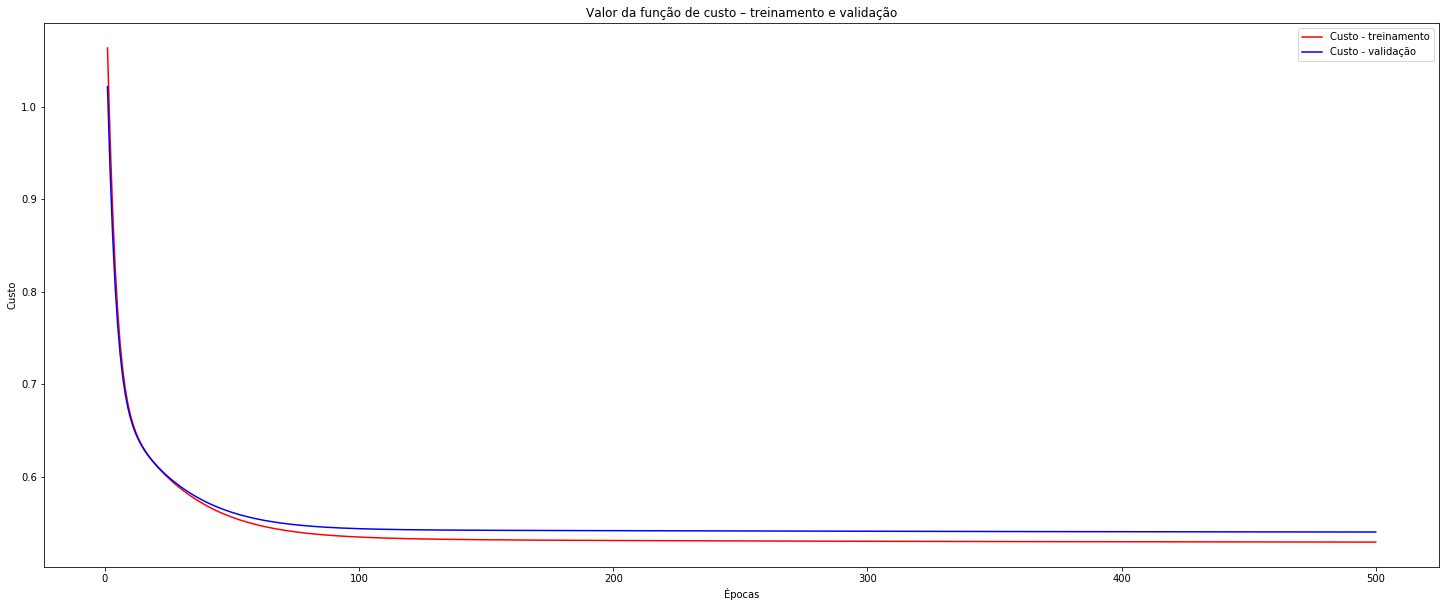

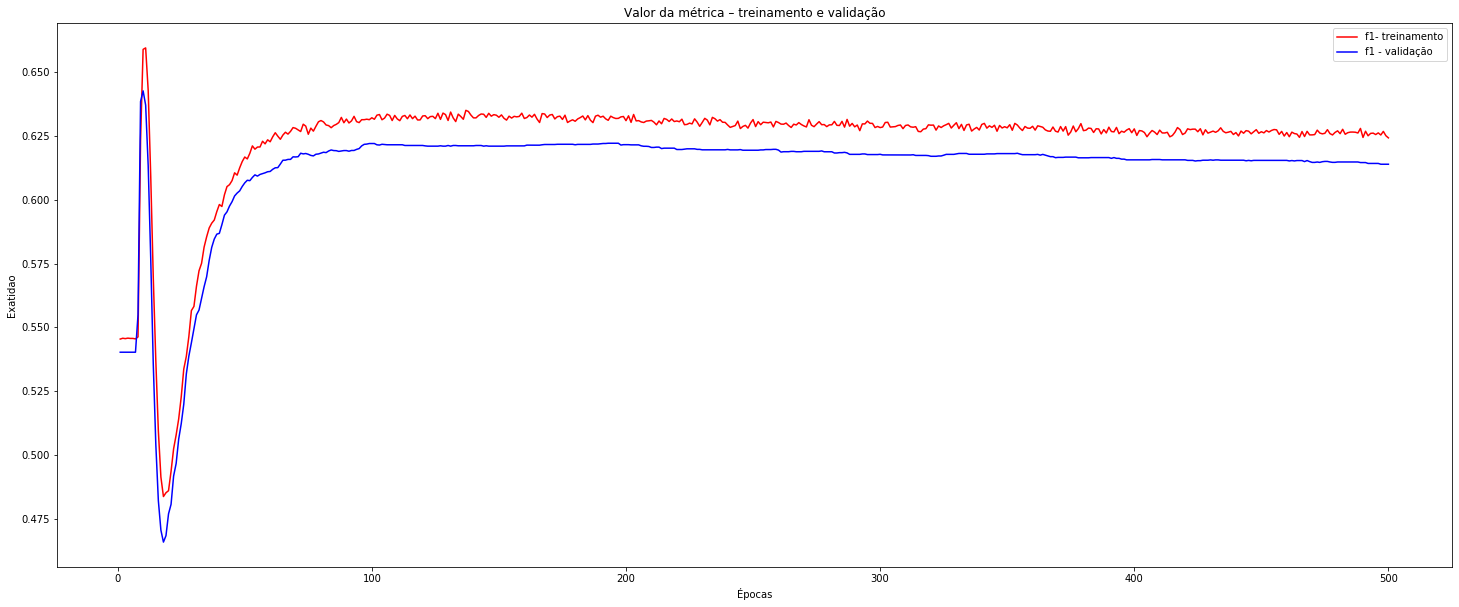

In [47]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [48]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model4.h5')

In [49]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (8,)))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [50]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.8180 - f1: 1.3882e-04 - val_loss: 0.8042 - val_f1: 0.0000e+00
Epoch 2/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.8097 - f1: 0.0000e+00 - val_loss: 0.7965 - val_f1: 0.0000e+00
Epoch 3/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.8018 - f1: 0.0000e+00 - val_loss: 0.7891 - val_f1: 0.0000e+00
Epoch 4/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.7943 - f1: 0.0000e+00 - val_loss: 0.7820 - val_f1: 0.0000e+00
Epoch 5/500
30736/30736 [==============================] - 1s 25us/step - loss: 0.7871 - f1: 0.0000e+00 - val_loss: 0.7753 - val_f1: 0.0000e+00
Epoch 6/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7803 - f1: 0.0000e+00 - val_loss: 0.7689 - val_f1: 0.0000e+00
Epoch 7/500
30736/30736 [==============================] - 1s 24us/step - loss: 0.7738 

30736/30736 [==============================] - 1s 26us/step - loss: 0.5492 - f1: 0.6011 - val_loss: 0.5539 - val_f1: 0.5916
Epoch 117/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5487 - f1: 0.6029 - val_loss: 0.5534 - val_f1: 0.5919
Epoch 118/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5481 - f1: 0.6031 - val_loss: 0.5530 - val_f1: 0.5929
Epoch 119/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5476 - f1: 0.6027 - val_loss: 0.5525 - val_f1: 0.5945
Epoch 120/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5470 - f1: 0.6038 - val_loss: 0.5521 - val_f1: 0.5941
Epoch 121/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5465 - f1: 0.6037 - val_loss: 0.5516 - val_f1: 0.5947
Epoch 122/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5460 - f1: 0.6053 - val_loss: 0.5512 - val_f1: 0.5959
Epoch 123/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5304 - f1: 0.6277 - val_loss: 0.5397 - val_f1: 0.6138
Epoch 235/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6253 - val_loss: 0.5397 - val_f1: 0.6138
Epoch 236/500
30736/30736 [==============================] - 1s 36us/step - loss: 0.5304 - f1: 0.6254 - val_loss: 0.5397 - val_f1: 0.6138
Epoch 237/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5304 - f1: 0.6255 - val_loss: 0.5397 - val_f1: 0.6140
Epoch 238/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5304 - f1: 0.6250 - val_loss: 0.5397 - val_f1: 0.6140
Epoch 239/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6281 - val_loss: 0.5397 - val_f1: 0.6140
Epoch 240/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5304 - f1: 0.6268 - val_loss: 0.5397 - val_f1: 0.6140
Epoch 241/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 26us/step - loss: 0.5300 - f1: 0.6253 - val_loss: 0.5399 - val_f1: 0.6161
Epoch 353/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5300 - f1: 0.6289 - val_loss: 0.5399 - val_f1: 0.6166
Epoch 354/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5300 - f1: 0.6273 - val_loss: 0.5399 - val_f1: 0.6161
Epoch 355/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5300 - f1: 0.6261 - val_loss: 0.5399 - val_f1: 0.6166
Epoch 356/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5300 - f1: 0.6283 - val_loss: 0.5399 - val_f1: 0.6161
Epoch 357/500
30736/30736 [==============================] - 1s 27us/step - loss: 0.5300 - f1: 0.6284 - val_loss: 0.5399 - val_f1: 0.6166
Epoch 358/500
30736/30736 [==============================] - 1s 34us/step - loss: 0.5300 - f1: 0.6274 - val_loss: 0.5399 - val_f1: 0.6166
Epoch 359/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 27us/step - loss: 0.5299 - f1: 0.6277 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 471/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5299 - f1: 0.6280 - val_loss: 0.5400 - val_f1: 0.6155
Epoch 472/500
30736/30736 [==============================] - 1s 26us/step - loss: 0.5299 - f1: 0.6275 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 473/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5299 - f1: 0.6271 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 474/500
30736/30736 [==============================] - 1s 29us/step - loss: 0.5299 - f1: 0.6276 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 475/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5299 - f1: 0.6284 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 476/500
30736/30736 [==============================] - 1s 28us/step - loss: 0.5299 - f1: 0.6273 - val_loss: 0.5400 - val_f1: 0.6157
Epoch 477/500
30736/30736 [=====================

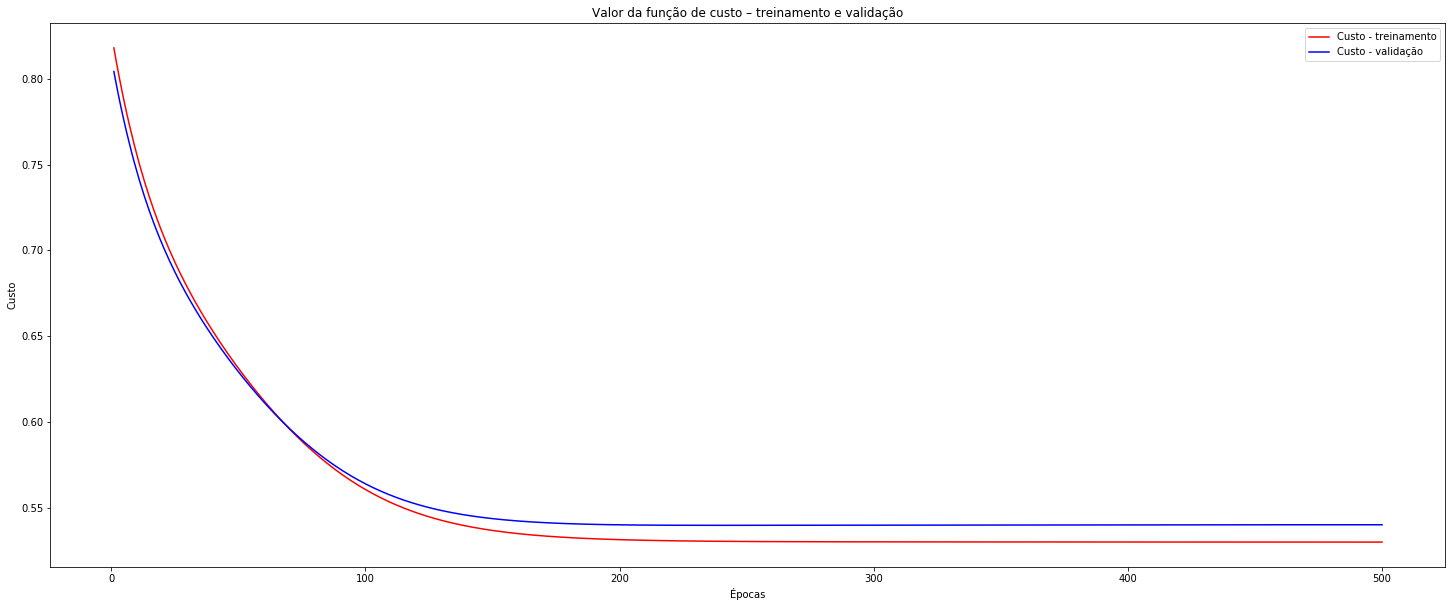

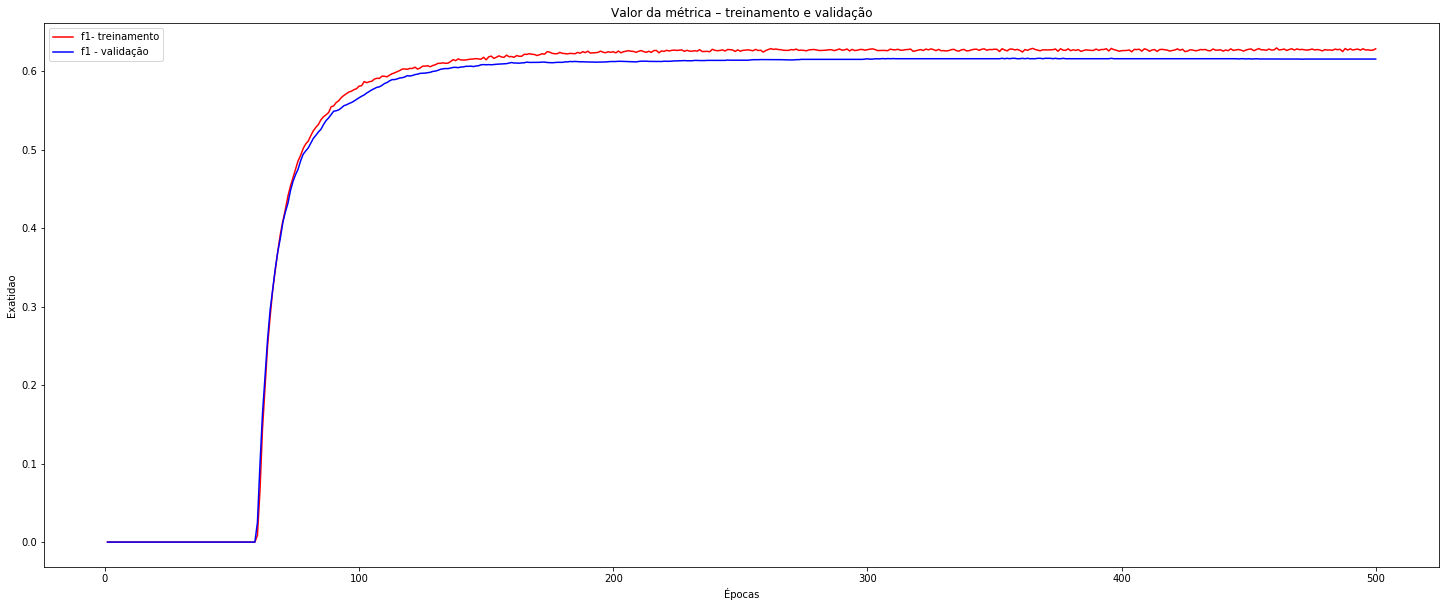

In [51]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [52]:
modelf.save('/home/ricardo/TCC/Undersampling/models/FinalModel/model5.h5')

In [55]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (11,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 3,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 58
Non-trainable params: 6
_________________________________________________________________


In [56]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.8090 - f1: 0.3093 - val_loss: 0.7975 - val_f1: 0.3053
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.7852 - f1: 0.3156 - val_loss: 0.7768 - val_f1: 0.3145
Epoch 3/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.7629 - f1: 0.3245 - val_loss: 0.7526 - val_f1: 0.3273
Epoch 4/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.7422 - f1: 0.3448 - val_loss: 0.7337 - val_f1: 0.3428
Epoch 5/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.7244 - f1: 0.3608 - val_loss: 0.7169 - val_f1: 0.3599
Epoch 6/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.7086 - f1: 0.3820 - val_loss: 0.7014 - val_f1: 0.3814
Epoch 7/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.6943 - f1: 0.4093 - val_loss: 0.6880 - val_f1: 0.4174

Epoch 120/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5355 - f1: 0.6227 - val_loss: 0.5410 - val_f1: 0.6134
Epoch 121/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5351 - f1: 0.6230 - val_loss: 0.5408 - val_f1: 0.6109
Epoch 122/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5349 - f1: 0.6233 - val_loss: 0.5408 - val_f1: 0.6129
Epoch 123/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5349 - f1: 0.6243 - val_loss: 0.5407 - val_f1: 0.6117
Epoch 124/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5344 - f1: 0.6216 - val_loss: 0.5407 - val_f1: 0.6117
Epoch 125/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5347 - f1: 0.6218 - val_loss: 0.5406 - val_f1: 0.6106
Epoch 126/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5343 - f1: 0.6238 - val_loss: 0.5405 - val_f1: 0.6110
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 31us/step - loss: 0.5323 - f1: 0.6095 - val_loss: 0.5385 - val_f1: 0.5999
Epoch 239/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5323 - f1: 0.6082 - val_loss: 0.5385 - val_f1: 0.5993
Epoch 240/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5321 - f1: 0.6084 - val_loss: 0.5385 - val_f1: 0.5996
Epoch 241/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5328 - f1: 0.6063 - val_loss: 0.5385 - val_f1: 0.5988
Epoch 242/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5318 - f1: 0.6069 - val_loss: 0.5385 - val_f1: 0.6002
Epoch 243/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5324 - f1: 0.6095 - val_loss: 0.5385 - val_f1: 0.5989
Epoch 244/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5323 - f1: 0.6098 - val_loss: 0.5385 - val_f1: 0.5998
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 31us/step - loss: 0.5317 - f1: 0.6076 - val_loss: 0.5383 - val_f1: 0.5975
Epoch 357/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5316 - f1: 0.6065 - val_loss: 0.5383 - val_f1: 0.5991
Epoch 358/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5319 - f1: 0.6094 - val_loss: 0.5383 - val_f1: 0.5983
Epoch 359/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5317 - f1: 0.6073 - val_loss: 0.5384 - val_f1: 0.5990
Epoch 360/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5318 - f1: 0.6051 - val_loss: 0.5383 - val_f1: 0.5987
Epoch 361/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5324 - f1: 0.6036 - val_loss: 0.5383 - val_f1: 0.5989
Epoch 362/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5319 - f1: 0.6055 - val_loss: 0.5384 - val_f1: 0.5990
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 31us/step - loss: 0.5310 - f1: 0.6070 - val_loss: 0.5383 - val_f1: 0.5985
Epoch 475/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5316 - f1: 0.6059 - val_loss: 0.5384 - val_f1: 0.5994
Epoch 476/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5316 - f1: 0.6060 - val_loss: 0.5383 - val_f1: 0.5986
Epoch 477/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5313 - f1: 0.6090 - val_loss: 0.5383 - val_f1: 0.5986
Epoch 478/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5313 - f1: 0.6068 - val_loss: 0.5384 - val_f1: 0.5991
Epoch 479/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5317 - f1: 0.6071 - val_loss: 0.5384 - val_f1: 0.5994
Epoch 480/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5318 - f1: 0.6040 - val_loss: 0.5383 - val_f1: 0.5983
Epoch 481/500
30736/30736 [=====================

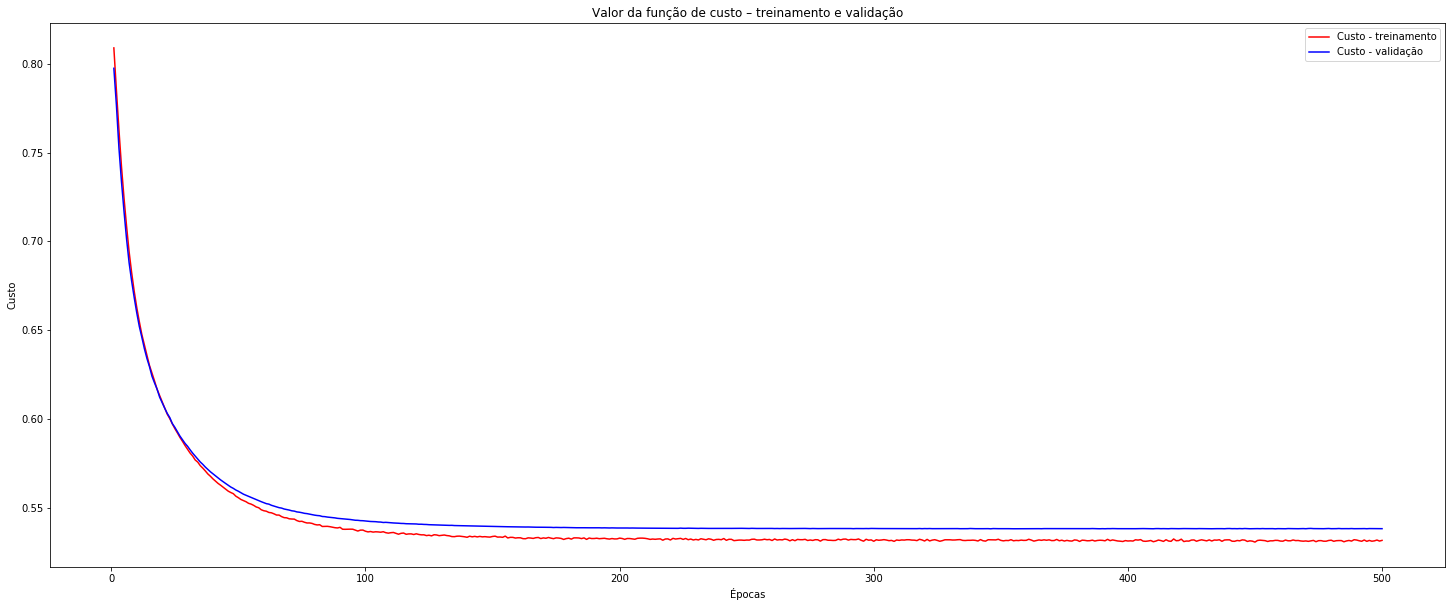

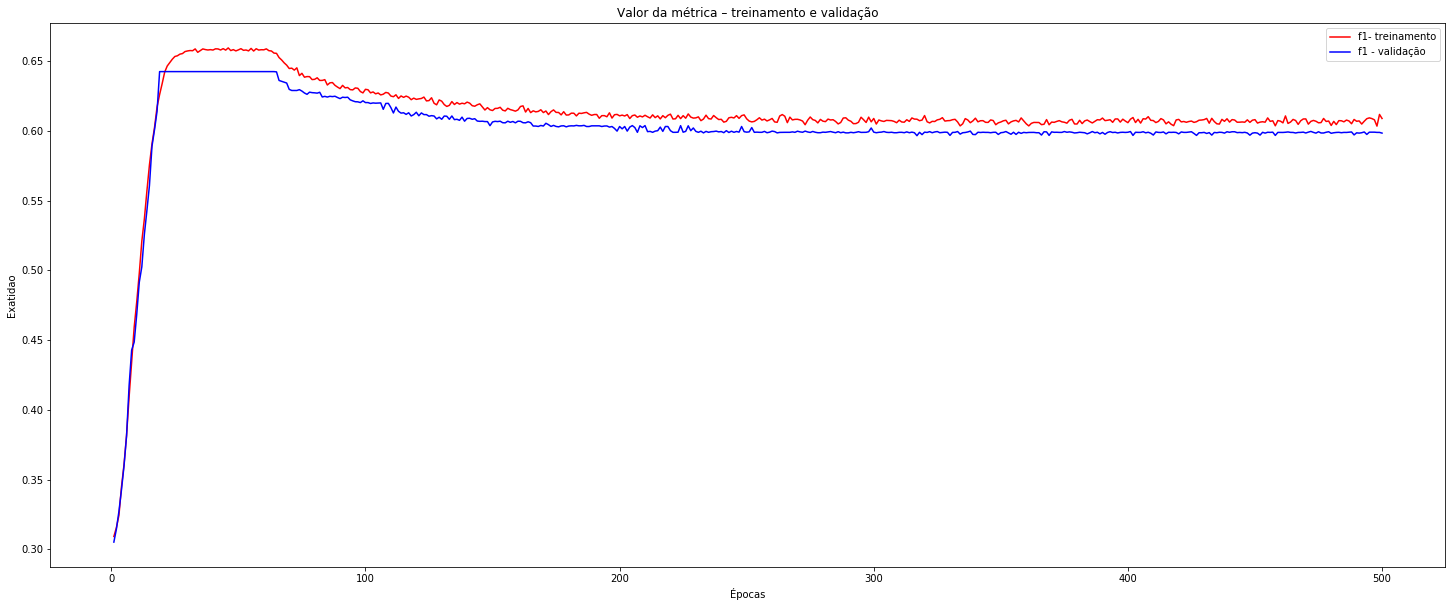

In [57]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [58]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 3, activation='tanh',input_shape = (8,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 3,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 27        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 55
Trainable params: 49
Non-trainable params: 6
_________________________________________________________________


In [59]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.6852 - f1: 0.3879 - val_loss: 0.6768 - val_f1: 0.4238
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6676 - f1: 0.4937 - val_loss: 0.6600 - val_f1: 0.5335
Epoch 3/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6516 - f1: 0.6051 - val_loss: 0.6449 - val_f1: 0.6372
Epoch 4/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6372 - f1: 0.6502 - val_loss: 0.6318 - val_f1: 0.6364
Epoch 5/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6249 - f1: 0.6528 - val_loss: 0.6204 - val_f1: 0.6354
Epoch 6/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6142 - f1: 0.6480 - val_loss: 0.6103 - val_f1: 0.6358
Epoch 7/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6044 - f1: 0.6498 - val_loss: 0.6018 - val_f1: 0.6357

Epoch 120/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5389 - f1: 0.6375 - val_loss: 0.5436 - val_f1: 0.6247
Epoch 121/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5382 - f1: 0.6389 - val_loss: 0.5436 - val_f1: 0.6246
Epoch 122/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5392 - f1: 0.6357 - val_loss: 0.5435 - val_f1: 0.6236
Epoch 123/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5397 - f1: 0.6338 - val_loss: 0.5436 - val_f1: 0.6244
Epoch 124/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5395 - f1: 0.6375 - val_loss: 0.5437 - val_f1: 0.6247
Epoch 125/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5382 - f1: 0.6382 - val_loss: 0.5434 - val_f1: 0.6244
Epoch 126/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5383 - f1: 0.6359 - val_loss: 0.5436 - val_f1: 0.6246
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 31us/step - loss: 0.5367 - f1: 0.6357 - val_loss: 0.5424 - val_f1: 0.6237
Epoch 239/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5379 - f1: 0.6327 - val_loss: 0.5424 - val_f1: 0.6222
Epoch 240/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5374 - f1: 0.6350 - val_loss: 0.5423 - val_f1: 0.6223
Epoch 241/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5374 - f1: 0.6331 - val_loss: 0.5423 - val_f1: 0.6226
Epoch 242/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5374 - f1: 0.6338 - val_loss: 0.5423 - val_f1: 0.6219
Epoch 243/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5365 - f1: 0.6359 - val_loss: 0.5423 - val_f1: 0.6220
Epoch 244/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5377 - f1: 0.6335 - val_loss: 0.5424 - val_f1: 0.6239
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 32us/step - loss: 0.5369 - f1: 0.6321 - val_loss: 0.5417 - val_f1: 0.6196
Epoch 357/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5366 - f1: 0.6326 - val_loss: 0.5417 - val_f1: 0.6208
Epoch 358/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5365 - f1: 0.6340 - val_loss: 0.5418 - val_f1: 0.6210
Epoch 359/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5364 - f1: 0.6323 - val_loss: 0.5415 - val_f1: 0.6170
Epoch 360/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5365 - f1: 0.6305 - val_loss: 0.5416 - val_f1: 0.6179
Epoch 361/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5354 - f1: 0.6335 - val_loss: 0.5416 - val_f1: 0.6190
Epoch 362/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5370 - f1: 0.6293 - val_loss: 0.5416 - val_f1: 0.6204
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 32us/step - loss: 0.5354 - f1: 0.6298 - val_loss: 0.5412 - val_f1: 0.6175
Epoch 475/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5362 - f1: 0.6306 - val_loss: 0.5412 - val_f1: 0.6175
Epoch 476/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5358 - f1: 0.6282 - val_loss: 0.5413 - val_f1: 0.6180
Epoch 477/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5354 - f1: 0.6307 - val_loss: 0.5414 - val_f1: 0.6174
Epoch 478/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5363 - f1: 0.6285 - val_loss: 0.5412 - val_f1: 0.6162
Epoch 479/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5359 - f1: 0.6314 - val_loss: 0.5411 - val_f1: 0.6176
Epoch 480/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5359 - f1: 0.6286 - val_loss: 0.5413 - val_f1: 0.6177
Epoch 481/500
30736/30736 [=====================

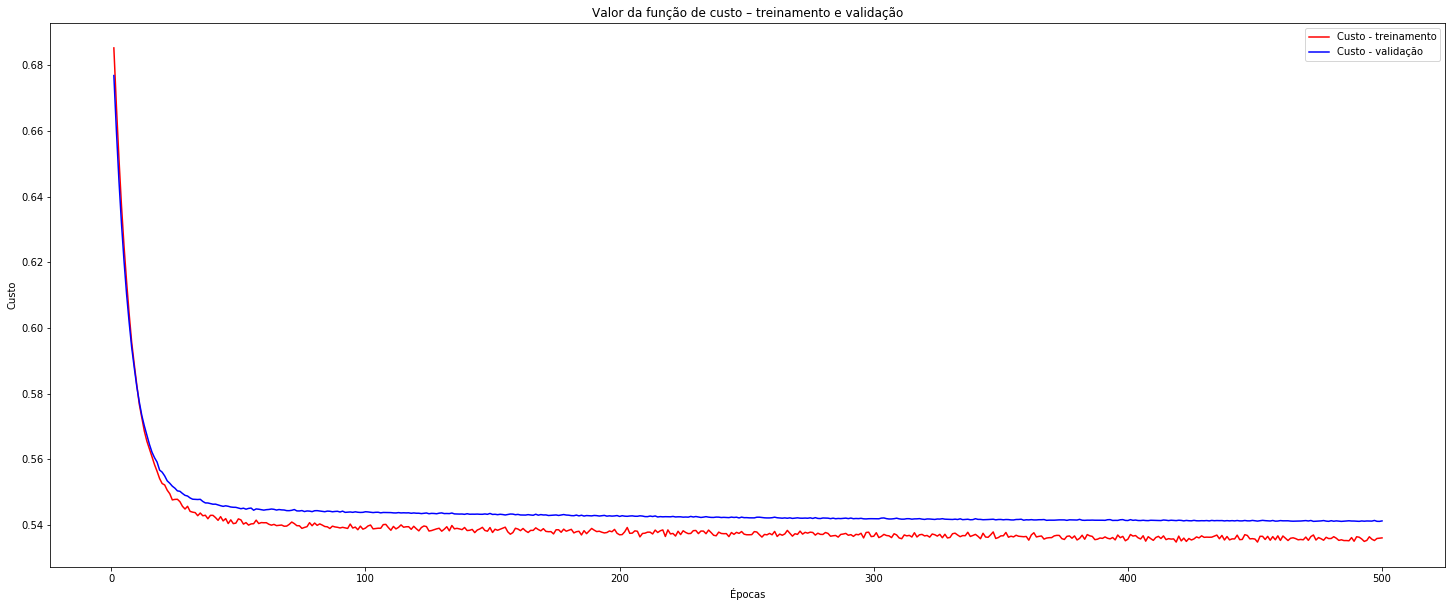

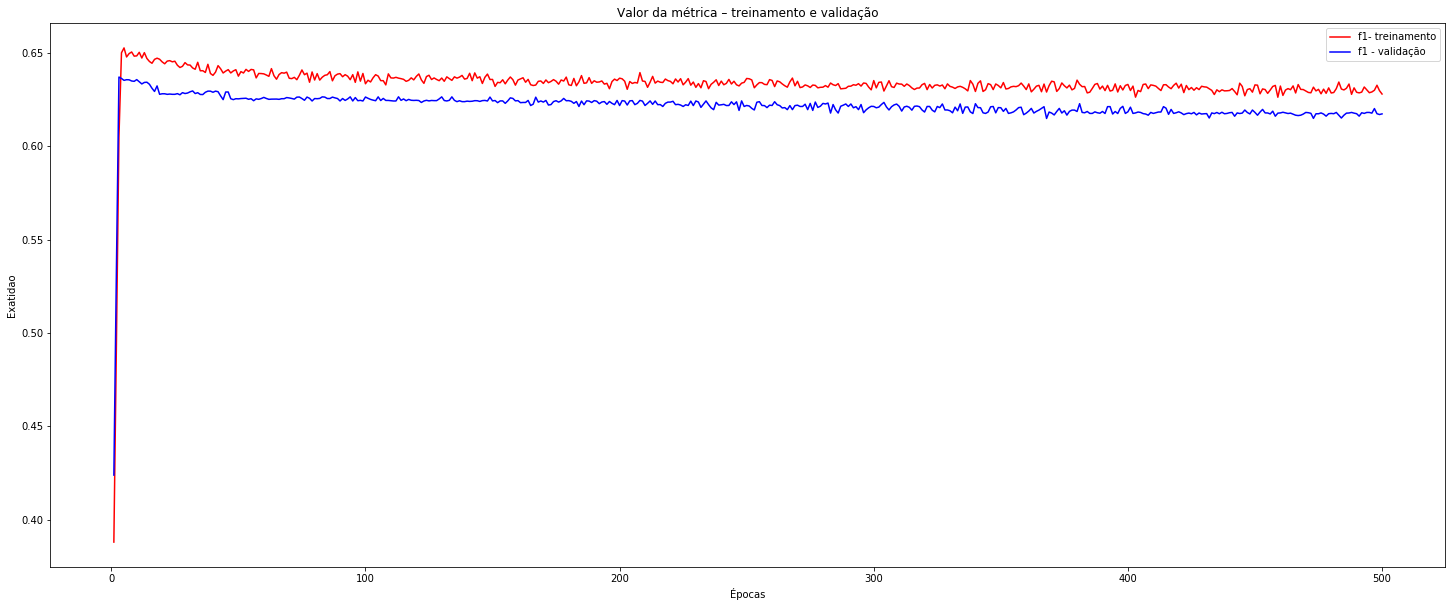

In [60]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [61]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (11,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 6,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 145
Trainable params: 133
Non-trainable params: 12
_________________________________________________________________


In [62]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0].loc[:,'hat_m1':'mean'],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1].loc[:,'hat_m1':'mean'],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.6629 - f1: 0.5732 - val_loss: 0.6371 - val_f1: 0.6426
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6204 - f1: 0.6572 - val_loss: 0.6103 - val_f1: 0.6426
Epoch 3/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5994 - f1: 0.6584 - val_loss: 0.5945 - val_f1: 0.6426
Epoch 4/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5845 - f1: 0.6588 - val_loss: 0.5818 - val_f1: 0.6426
Epoch 5/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5740 - f1: 0.6580 - val_loss: 0.5734 - val_f1: 0.6423
Epoch 6/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5656 - f1: 0.6588 - val_loss: 0.5656 - val_f1: 0.6437
Epoch 7/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5608 - f1: 0.6572 - val_loss: 0.5635 - val_f1: 0.6436

Epoch 120/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5314 - f1: 0.6219 - val_loss: 0.5410 - val_f1: 0.6040
Epoch 121/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5313 - f1: 0.6245 - val_loss: 0.5411 - val_f1: 0.6061
Epoch 122/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5321 - f1: 0.6218 - val_loss: 0.5410 - val_f1: 0.6056
Epoch 123/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5321 - f1: 0.6212 - val_loss: 0.5410 - val_f1: 0.6047
Epoch 124/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5315 - f1: 0.6218 - val_loss: 0.5411 - val_f1: 0.6053
Epoch 125/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5318 - f1: 0.6218 - val_loss: 0.5410 - val_f1: 0.6039
Epoch 126/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5319 - f1: 0.6219 - val_loss: 0.5411 - val_f1: 0.6060
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 32us/step - loss: 0.5308 - f1: 0.6236 - val_loss: 0.5415 - val_f1: 0.6022
Epoch 239/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5316 - f1: 0.6191 - val_loss: 0.5416 - val_f1: 0.6042
Epoch 240/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5312 - f1: 0.6193 - val_loss: 0.5417 - val_f1: 0.6047
Epoch 241/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5304 - f1: 0.6240 - val_loss: 0.5416 - val_f1: 0.6032
Epoch 242/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5315 - f1: 0.6208 - val_loss: 0.5415 - val_f1: 0.6033
Epoch 243/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5309 - f1: 0.6211 - val_loss: 0.5416 - val_f1: 0.6043
Epoch 244/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5312 - f1: 0.6218 - val_loss: 0.5417 - val_f1: 0.6041
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 31us/step - loss: 0.5303 - f1: 0.6200 - val_loss: 0.5418 - val_f1: 0.6013
Epoch 357/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5304 - f1: 0.6202 - val_loss: 0.5417 - val_f1: 0.5997
Epoch 358/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5304 - f1: 0.6215 - val_loss: 0.5416 - val_f1: 0.5974
Epoch 359/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5307 - f1: 0.6216 - val_loss: 0.5417 - val_f1: 0.5984
Epoch 360/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5308 - f1: 0.6217 - val_loss: 0.5420 - val_f1: 0.6044
Epoch 361/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5306 - f1: 0.6199 - val_loss: 0.5419 - val_f1: 0.6040
Epoch 362/500
30736/30736 [==============================] - 1s 32us/step - loss: 0.5307 - f1: 0.6202 - val_loss: 0.5418 - val_f1: 0.6023
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 31us/step - loss: 0.5307 - f1: 0.6200 - val_loss: 0.5419 - val_f1: 0.6003
Epoch 475/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5303 - f1: 0.6206 - val_loss: 0.5419 - val_f1: 0.5997
Epoch 476/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5306 - f1: 0.6220 - val_loss: 0.5418 - val_f1: 0.6001
Epoch 477/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5299 - f1: 0.6229 - val_loss: 0.5417 - val_f1: 0.5989
Epoch 478/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5305 - f1: 0.6217 - val_loss: 0.5418 - val_f1: 0.5998
Epoch 479/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5303 - f1: 0.6198 - val_loss: 0.5421 - val_f1: 0.6017
Epoch 480/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5300 - f1: 0.6197 - val_loss: 0.5421 - val_f1: 0.6016
Epoch 481/500
30736/30736 [=====================

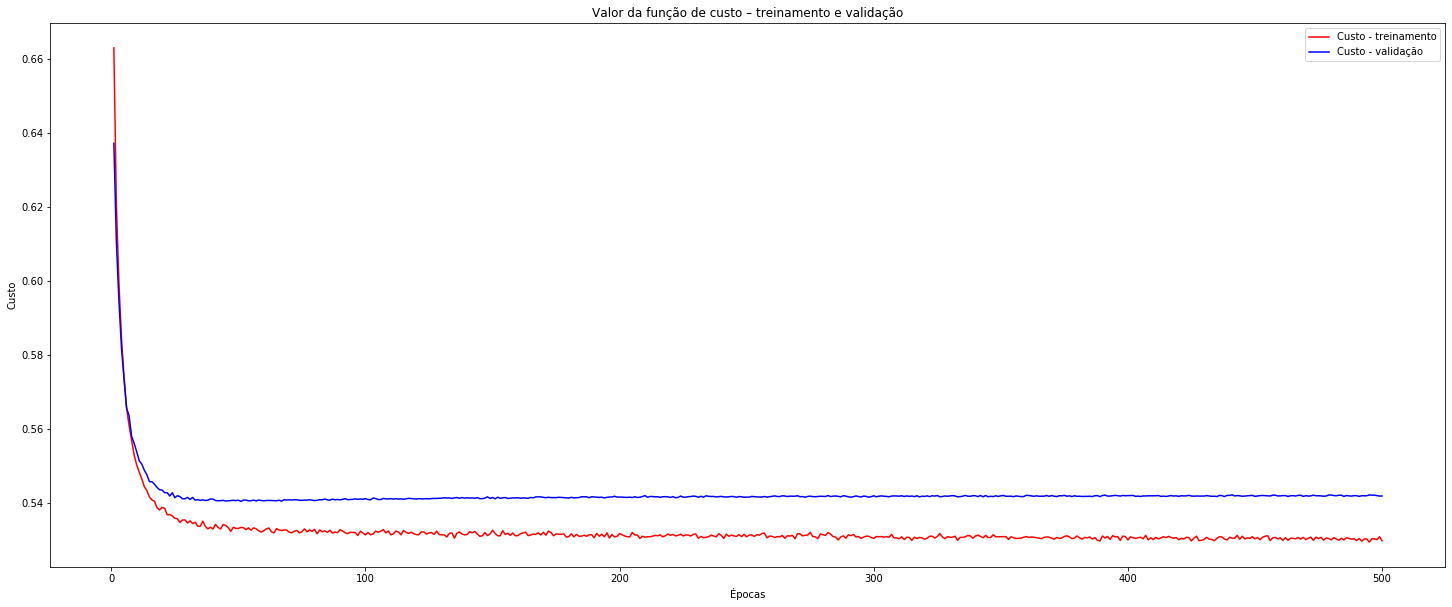

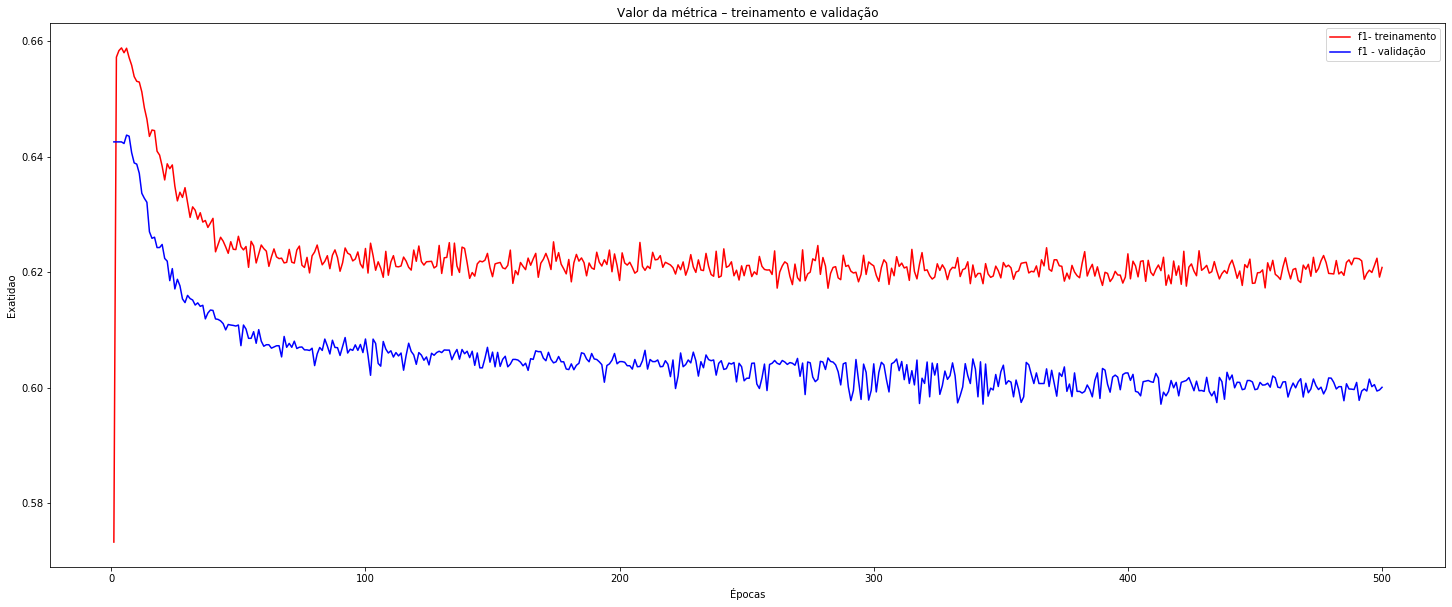

In [63]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [64]:
K.clear_session()

modelf = models.Sequential()
modelf.add(layers.Dense(units = 6, activation='tanh',input_shape = (8,)))
modelf.add(BatchNormalization())
modelf.add(layers.Dense(units = 6,activation = 'tanh'))
modelf.add(layers.Dense(units = 1,activation = 'sigmoid'))

modelf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 115
Non-trainable params: 12
_________________________________________________________________


In [65]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
modelf.compile(loss = 'binary_crossentropy',metrics=[f1],optimizer = mom)
history = modelf.fit(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[0]['layer'],epochs = 500,batch_size=32, 
                     validation_data =(dataf[1][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5','prob0_m5','prod','mean']],dataf[1]['layer']))

Train on 30736 samples, validate on 6662 samples
Epoch 1/500
30736/30736 [==============================] - 1s 41us/step - loss: 0.6613 - f1: 0.6385 - val_loss: 0.6424 - val_f1: 0.6451
Epoch 2/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6357 - f1: 0.6479 - val_loss: 0.6259 - val_f1: 0.6416
Epoch 3/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6201 - f1: 0.6507 - val_loss: 0.6119 - val_f1: 0.6419
Epoch 4/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.6085 - f1: 0.6499 - val_loss: 0.6034 - val_f1: 0.6417
Epoch 5/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5991 - f1: 0.6497 - val_loss: 0.5948 - val_f1: 0.6399
Epoch 6/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5912 - f1: 0.6515 - val_loss: 0.5885 - val_f1: 0.6390
Epoch 7/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5849 - f1: 0.6493 - val_loss: 0.5826 - val_f1: 0.6392

Epoch 120/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5391 - f1: 0.6360 - val_loss: 0.5434 - val_f1: 0.6251
Epoch 121/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5387 - f1: 0.6345 - val_loss: 0.5434 - val_f1: 0.6257
Epoch 122/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5393 - f1: 0.6345 - val_loss: 0.5433 - val_f1: 0.6249
Epoch 123/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5384 - f1: 0.6383 - val_loss: 0.5433 - val_f1: 0.6245
Epoch 124/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5390 - f1: 0.6367 - val_loss: 0.5434 - val_f1: 0.6246
Epoch 125/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5390 - f1: 0.6372 - val_loss: 0.5435 - val_f1: 0.6260
Epoch 126/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5383 - f1: 0.6361 - val_loss: 0.5434 - val_f1: 0.6256
Epoch 127/500
30736/30736 [=======

30736/30736 [==============================] - 1s 30us/step - loss: 0.5376 - f1: 0.6317 - val_loss: 0.5431 - val_f1: 0.6237
Epoch 239/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5374 - f1: 0.6346 - val_loss: 0.5426 - val_f1: 0.6190
Epoch 240/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5381 - f1: 0.6307 - val_loss: 0.5427 - val_f1: 0.6214
Epoch 241/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5377 - f1: 0.6324 - val_loss: 0.5427 - val_f1: 0.6213
Epoch 242/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5369 - f1: 0.6355 - val_loss: 0.5426 - val_f1: 0.6195
Epoch 243/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5364 - f1: 0.6350 - val_loss: 0.5428 - val_f1: 0.6220
Epoch 244/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5379 - f1: 0.6313 - val_loss: 0.5426 - val_f1: 0.6207
Epoch 245/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5372 - f1: 0.6304 - val_loss: 0.5426 - val_f1: 0.6188
Epoch 357/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5366 - f1: 0.6302 - val_loss: 0.5425 - val_f1: 0.6176
Epoch 358/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5360 - f1: 0.6318 - val_loss: 0.5426 - val_f1: 0.6188
Epoch 359/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5371 - f1: 0.6313 - val_loss: 0.5424 - val_f1: 0.6173
Epoch 360/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5357 - f1: 0.6332 - val_loss: 0.5426 - val_f1: 0.6178
Epoch 361/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5362 - f1: 0.6306 - val_loss: 0.5424 - val_f1: 0.6177
Epoch 362/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5360 - f1: 0.6295 - val_loss: 0.5426 - val_f1: 0.6185
Epoch 363/500
30736/30736 [=====================

30736/30736 [==============================] - 1s 30us/step - loss: 0.5355 - f1: 0.6295 - val_loss: 0.5425 - val_f1: 0.6158
Epoch 475/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5361 - f1: 0.6303 - val_loss: 0.5426 - val_f1: 0.6164
Epoch 476/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5356 - f1: 0.6296 - val_loss: 0.5426 - val_f1: 0.6159
Epoch 477/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5352 - f1: 0.6296 - val_loss: 0.5426 - val_f1: 0.6157
Epoch 478/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5356 - f1: 0.6317 - val_loss: 0.5425 - val_f1: 0.6153
Epoch 479/500
30736/30736 [==============================] - 1s 31us/step - loss: 0.5355 - f1: 0.6282 - val_loss: 0.5425 - val_f1: 0.6141
Epoch 480/500
30736/30736 [==============================] - 1s 30us/step - loss: 0.5358 - f1: 0.6302 - val_loss: 0.5425 - val_f1: 0.6146
Epoch 481/500
30736/30736 [=====================

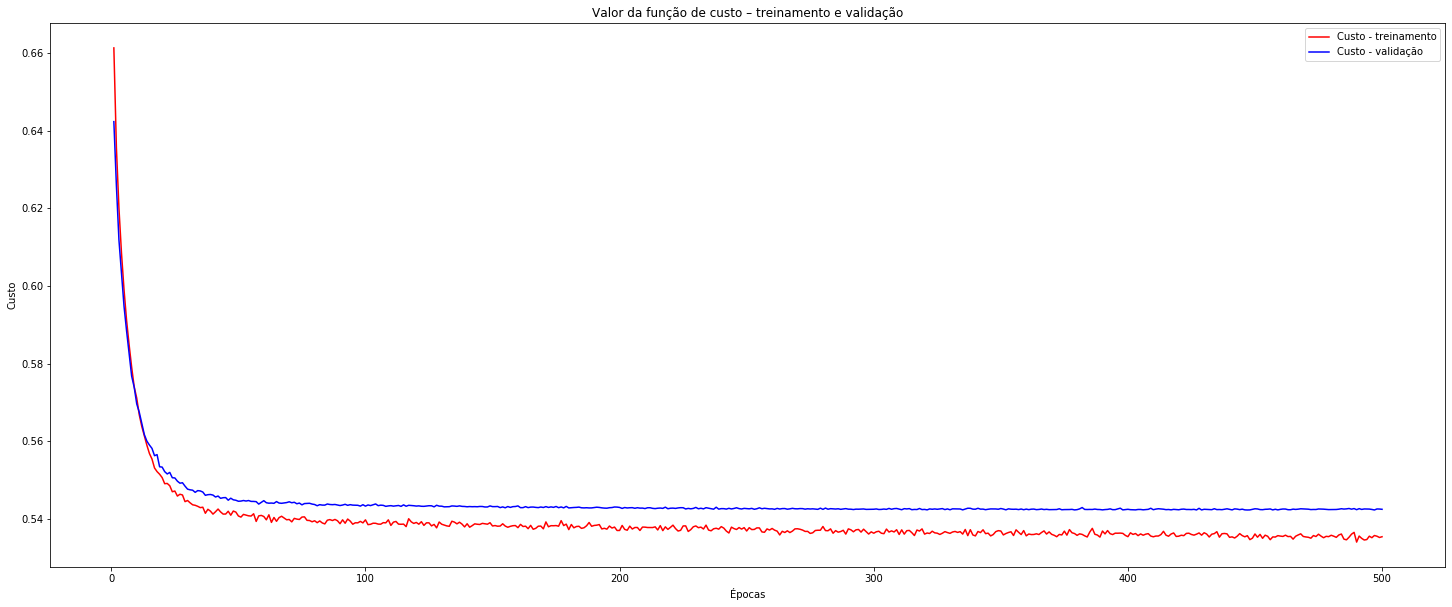

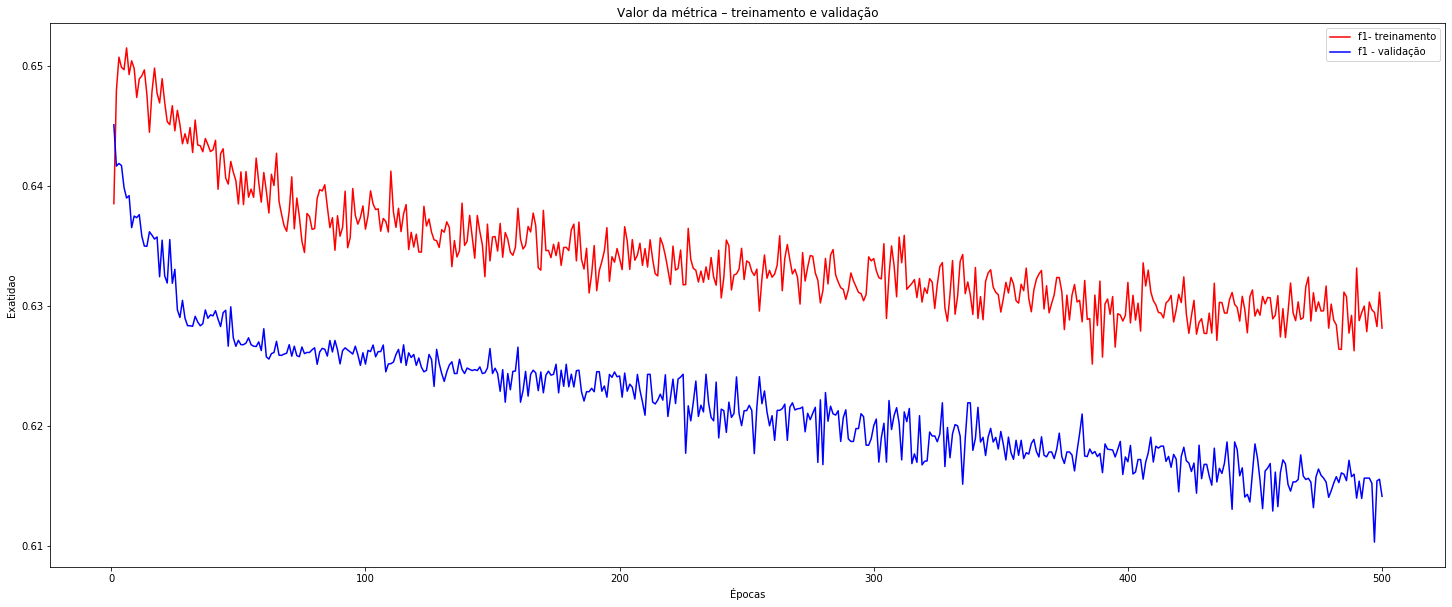

In [66]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

# Now we will put all answers together. When the three algorithms agree that it's an anomaly we will put the answer 1 (2008 cases), When the three algorithms agree that it's not an anomaly we will put the answer 0 (12807 cases) and for the others cases we will take the answers form the finals models that we traing above.

- ## Adding a column with answer  = 1 and answer  = 0, for the respective cases

In [46]:
for i in range(len(p0)):
    p0[i]['ans'] = 0
    p1[i]['ans'] = 1

In [47]:
p0[0].head()

,hat_m1,prob1_m1,prob0_m1,hat_m3,prob1_m3,prob0_m3,hat_m5,prob1_m5,prob0_m5,prod,mean,layer,ans
id,,,,,,,,,,,,,
0,0.0,0.065888,0.065888,0.0,0.067238,0.932762,0.0,0.098672,0.901328,0.090198,0.077266,0.0,0
4,0.0,0.073392,0.073392,0.0,0.077893,0.922107,0.0,0.079033,0.920967,0.092289,0.076773,0.0,0
18,0.0,0.022837,0.022837,0.0,0.023993,0.976007,0.0,0.038006,0.961994,0.053791,0.028279,1.0,0
19,0.0,0.076864,0.076864,0.0,0.080877,0.919123,0.0,0.085429,0.914571,0.094769,0.081057,0.0,0
25,0.0,0.020442,0.020442,0.0,0.022660,0.977340,0.0,0.026525,0.973475,0.050343,0.023209,0.0,0


In [48]:
p1[0].head()

,hat_m1,prob1_m1,prob0_m1,hat_m3,prob1_m3,prob0_m3,hat_m5,prob1_m5,prob0_m5,prod,mean,layer,ans
id,,,,,,,,,,,,,
3,1.0,0.963048,0.963048,1.0,0.962285,0.037715,1.0,0.964124,0.035876,0.327134,0.963153,1.0,1
31,1.0,0.947232,0.947232,1.0,0.950147,0.049853,1.0,0.963277,0.036723,0.325487,0.953552,1.0,1
49,1.0,0.947350,0.947350,1.0,0.946451,0.053549,1.0,0.952180,0.047820,0.324662,0.948661,1.0,1
134,1.0,0.918150,0.918150,1.0,0.913285,0.086715,1.0,0.933640,0.066360,0.319995,0.921692,1.0,1
141,1.0,0.967282,0.967282,1.0,0.968647,0.031353,1.0,0.970287,0.029713,0.328081,0.968739,1.0,1


- ## Putting P0 and P1 together

In [49]:
p = []
for i in range(len(p0)):
    aux = pd.concat([p0[i],p1[i]])
    aux = aux.sort_index()
    p.append(aux)

- ## Chosing the best model

In [50]:
path1 = path+'Undersampling/models/FinalModel/'

In [51]:
model0 = load_model(path1+'model0.h5', custom_objects={'f1': f1})
model1 = load_model(path1+'model1.h5', custom_objects={'f1': f1})
model2 = load_model(path1+'model2.h5', custom_objects={'f1': f1})
model3 = load_model(path1+'model3.h5', custom_objects={'f1': f1})
model4 = load_model(path1+'model4.h5', custom_objects={'f1': f1})
model5 = load_model(path1+'model5.h5', custom_objects={'f1': f1})
models = [model0,model1,model2,model3,model4,model5]

In [52]:
prob = []

for i in range(len(models)):
    if(models[i].input_shape[1]) == 11:
        prob.append(models[i].predict(dataf[0].loc[:,'hat_m1':'mean']))
    else:
        prob.append(models[i].predict(dataf[0][['prob1_m1','prob0_m1','prob1_m3','prob0_m3','prob1_m5',
                                                     'prob0_m5','prod','mean']]))

In [53]:
f1_models = []
threshold_list = np.arange(0,1,0.01)
threshold = []
for i in range(len(models)):
    precision,recall,f1_,y_h = choosing_threshold(dataf[0]['layer'],prob[i],threshold_list)
    f1_models.append(max(f1_))
    threshold.append(f1_.index(max(f1_))*0.01)

#### How we can see, the best model is model 2

In [54]:
f1_models

[0.6651949412557061,
 0.6672808229694457,
 0.6668723962351488,
 0.6661236579044798,
 0.667051001191437,
 0.6669481441676581]

#### Now with this results, we will make predictions for the train, val and  test data.

In [55]:
threshold = threshold[f1_models.index(max(f1_models))]
y_hat = []
for i in range(len(dataf)):
    y_prob = models[f1_models.index(max(f1_models))].predict(dataf[i][['prob1_m1','prob0_m1','prob1_m3','prob0_m3',
                                                                       'prob1_m5','prob0_m5','prod','mean']])
    y_hat.append(predict_threshold(y_prob,threshold))

#### Putting the answers from the final model with the current DataFrame

In [56]:
for i in range(len(dataf)):
    dataf[i]['ans'] = y_hat[i]

#### Concatenating P and Dataf

In [72]:
fdata = []
for i in range(len(p)):
    aux = pd.concat([dataf[i],p[i]])
    fdata.append(aux.sort_index())

In [78]:
fdata[0].head()

,hat_m1,prob1_m1,prob0_m1,hat_m3,prob1_m3,prob0_m3,hat_m5,prob1_m5,prob0_m5,prod,mean,layer,ans
id,,,,,,,,,,,,,
0,0.0,0.065888,0.065888,0.0,0.067238,0.932762,0.0,0.098672,0.901328,0.090198,0.077266,0.0,0
1,0.0,0.131278,0.131278,0.0,0.131740,0.868260,1.0,0.126287,0.873713,0.120045,0.129769,0.0,0
2,0.0,0.293125,0.293125,0.0,0.281910,0.718090,1.0,0.322745,0.677255,0.181904,0.299260,1.0,0
3,1.0,0.963048,0.963048,1.0,0.962285,0.037715,1.0,0.964124,0.035876,0.327134,0.963153,1.0,1
4,0.0,0.073392,0.073392,0.0,0.077893,0.922107,0.0,0.079033,0.920967,0.092289,0.076773,0.0,0


# Ploting the Confusion Matrix for the train, val and test data

Normalized confusion matrix
[[0.81643958 0.18356042]
 [0.25008841 0.74991159]]
Normalized confusion matrix
[[0.8030683  0.1969317 ]
 [0.25687458 0.74312542]]
Normalized confusion matrix
[[0.80689858 0.19310142]
 [0.25361102 0.74638898]]


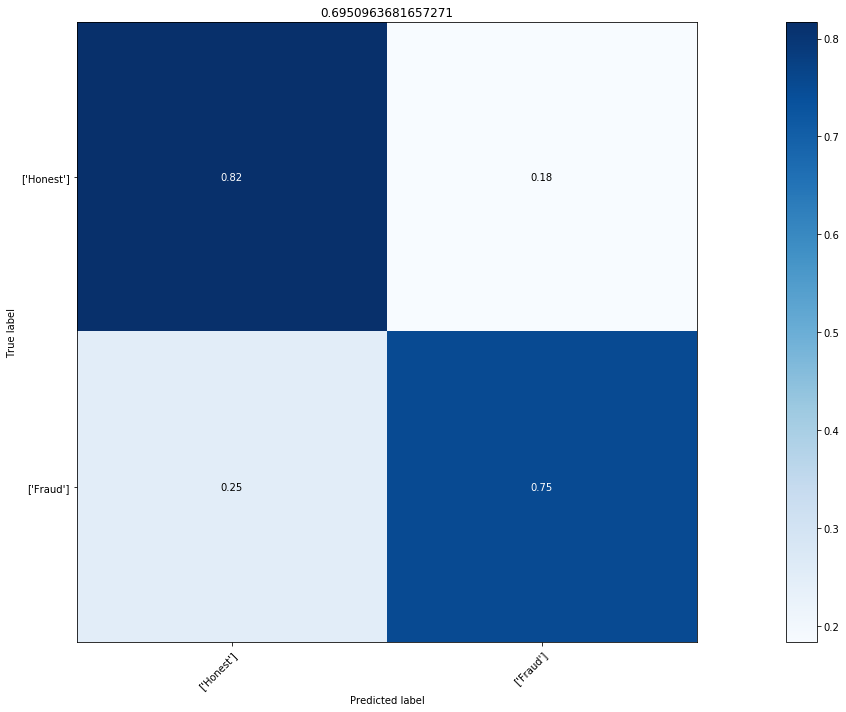

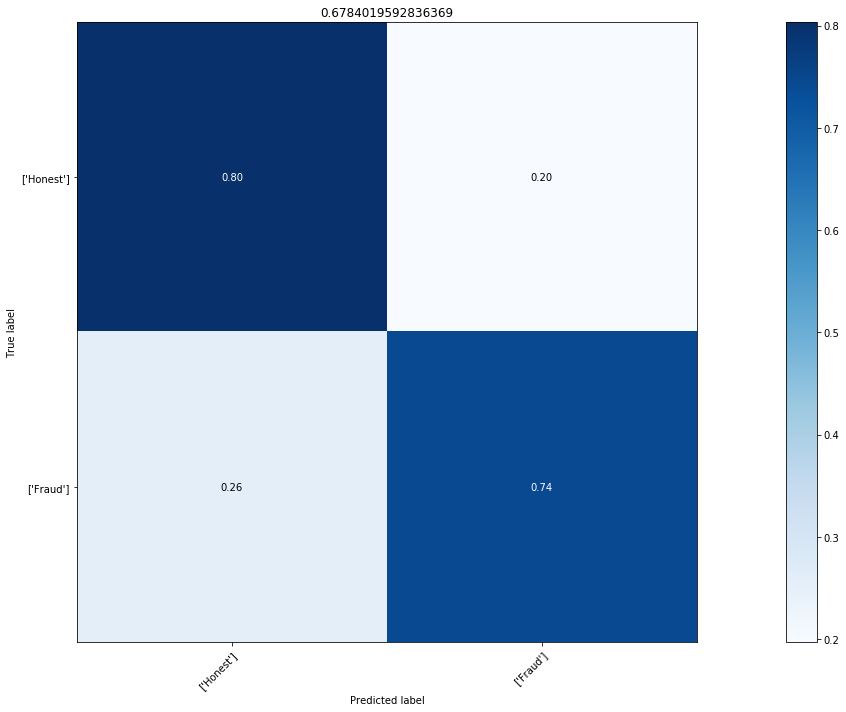

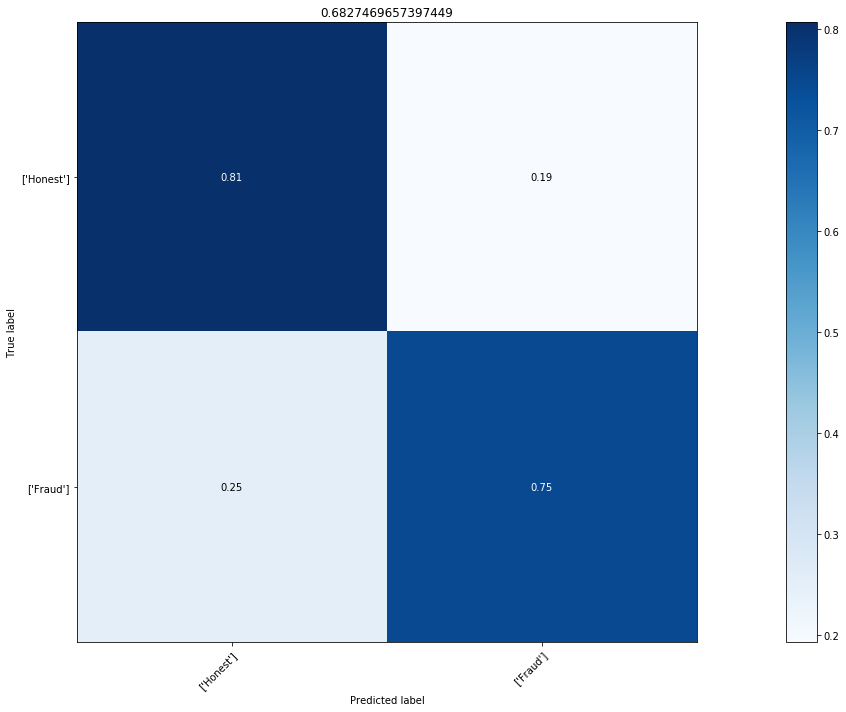

In [89]:
for i in range(len(fdata)):
    plot_confusion_matrix(fdata[i]['layer'].astype(int), fdata[i]['ans'],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(fdata[i]['layer'], fdata[i]['ans']),
                          cmap=plt.cm.Blues)